# Chapter 9: Images

Accompanying code for the book [The Art of Feature Engineering](http://artoffeatureengineering.com).

This notebook plus notebooks for the other chapters are available online at https://github.com/DrDub/artfeateng


## MIT License

Copyright 2019 Pablo Duboue

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Limitations

* Simple python intented for people coming from other languages that plan to use the ideas described in the book outside of Python.
* Many of these techniques are available as library calls. They are spelled out as for teaching purposes.
* Resource limitations:
 * At most one day of running time per notebook.
 * No GPU required.
 * Minimal dependencies.
 * At most 8Gb of RAM.
* Due to resource limitations, these notebooks do not undergo as much hyperparameter tuning as necessary. This is a shortcoming of these case studies, keep it in mind if you want to follow a similar path with your experiments.
* To help readers try variants of some cells in isolation, the cells are easily executable without having to re-run the whole notebook. As such, most cells read everything they need from disk and write all their results back into disk, which is unnecessary with normal notebooks. The code for each cell might look long and somewhat unusual. In a sense, each cell tries to be a separate Python program.
* I dislike Pandas so these notebooks are Pandas-free, which might seem unusual to some.

Get the GPS coordinates for all cities (Cell #1).

In [1]:
# CELL 1
from collections import OrderedDict

geo_id_to_uri = OrderedDict()
with open("ch6_cell1_cities1000_links.ttl") as f:
    for line in f:
        fields = line.split(' ')
        _id = fields[2]
        _id = _id.split('/')[-2]
        geo_id_to_uri[_id] = fields[0]
    
print("Linked cities: {:,}".format(len(geo_id_to_uri)))
geo_id_to_gps = dict()
found = 0
with open("cities1000.txt") as f:
    for line in f:
        fields = line.split('\t')
        _id = fields[0]
        lat = fields[4]
        lon = fields[5]
        if _id in geo_id_to_uri:
            geo_id_to_gps[_id] = (lat, lon)
            found += 1
                            
print("With coordinates: {:,} ({:%})".format(found, found/len(geo_id_to_uri)))
    
with open("ch9_cell1_cities1000_gps.tsv", "w") as w:
    w.write("name\tgeo_id\tlat\tlon\n")
    for _id in geo_id_to_uri:
        if _id in geo_id_to_gps:
            lat, lon = geo_id_to_gps[_id]
            w.write("{}\t{}\t{}\t{}\n".format(geo_id_to_uri[_id], _id, lat, lon))

Linked cities: 80,199
With coordinates: 80,199 (100.000000%)


Generate tile lists (Cell #2).

In [2]:
# CELL 2

PARAM_WIDTH_TILES = 2560
PARAM_HEIGHT_TILES = 1280

PARAM_TOP_LON = -180
PARAM_TOP_LAT = 90

PARAM_TILE_SIZE = 512
PARAM_BOX_SIZE = 128 # output tiles around a city

def cell2_to_tile_pixel(lat, lon):
    tile_row = (PARAM_TOP_LAT - lat) / 360 * PARAM_WIDTH_TILES
    tile_col = (lon - PARAM_TOP_LON) / 180 * PARAM_HEIGHT_TILES

    pixel_x = (tile_col - int(tile_col)) * PARAM_TILE_SIZE
    pixel_y = (tile_row - int(tile_row)) * PARAM_TILE_SIZE
    
    tile_row = int(tile_row)
    tile_col = int(tile_col)
    return tile_row, tile_col, int(pixel_x), int(pixel_y)

def tiles_to_fetch(lat, lon):
    tile_row, tile_col, pixel_x, pixel_y = cell2_to_tile_pixel(lat, lon)
    
    result = [ (tile_row, tile_col) ]
    tile_col_m1 = (tile_col - 1 + PARAM_HEIGHT_TILES) % PARAM_HEIGHT_TILES
    tile_col_p1 = (tile_col + 1) % PARAM_HEIGHT_TILES
    tile_row_m1 = (tile_row - 1 + PARAM_WIDTH_TILES) % PARAM_WIDTH_TILES
    tile_row_p1 = (tile_row + 1) % PARAM_WIDTH_TILES
    
    if pixel_x < PARAM_BOX_SIZE / 2:
        result.append( (tile_row_m1, tile_col))
    if pixel_y < PARAM_BOX_SIZE / 2:
        result.append( (tile_row, tile_col_m1))
    if pixel_x < PARAM_BOX_SIZE / 2 and pixel_y < PARAM_BOX_SIZE / 2:
        result.append( (tile_row_m1, tile_col_m1))
    if PARAM_TILE_SIZE - pixel_x < PARAM_BOX_SIZE / 2: 
        result.append( (tile_row_p1, tile_col))
    if PARAM_TILE_SIZE - pixel_y < PARAM_BOX_SIZE / 2: 
        result.append( (tile_row, tile_col_p1))
    if PARAM_TILE_SIZE - pixel_x < PARAM_BOX_SIZE /2 and PARAM_TILE_SIZE - pixel_y < PARAM_BOX_SIZE / 2: 
        result.append( (tile_row_p1, tile_col_p1))
    return result

tiles = set()
with open("ch9_cell1_cities1000_gps.tsv") as f:
    next(f) # header
    for line in f:
        _, _, lat, lon = line.split("\t")
        for row, col in tiles_to_fetch(float(lat), float(lon)):
            tiles.add("{}\t{}".format(row,col))
            
print("To fetch: {:,} tiles".format(len(tiles)))

with open("ch9_cell2_tiles_zoom11.tsv", "w") as w:
    w.write("\n".join(sorted(tiles)) + "\n")

To fetch: 68,304 tiles


The tiles are fetched through a script and available in the tiles/ folder. From there, we can extract boxes surrounding a given point. Cell #3 extracs boxes of size $64 \times 64$.

In [3]:
# CELL 3
import os
import cv2
import numpy as np

PARAM_TILE_SIZE = 512
PARAM_BOX_SIZE  = 64
PARAM_DATA_PATH   = './tiles'
PARAM_OUTPUT_PATH = './boxes'

if not os.path.exists(PARAM_OUTPUT_PATH):
    os.mkdir(PARAM_OUTPUT_PATH)

cities = list()
with open("ch9_cell1_cities1000_gps.tsv") as f:
    next(f) # header
    for line in f:
        uri, geoid, lat, lon = line.split("\t")
        cities.append( (uri, geoid, float(lat), float(lon)) )

target = np.zeros( (PARAM_BOX_SIZE, PARAM_BOX_SIZE, 3), dtype='uint8' )
large = np.zeros( (512 * 2, 512 * 2, 3), dtype='uint8')

missing_tile = set()
multi_tile = 0
written = 0
for uri, geoid, lat, lon in cities:
    tile_row, tile_col, pixel_x, pixel_y = cell2_to_tile_pixel(lat, lon)

    img_file = "{}/{}-{}.jpeg".format(PARAM_DATA_PATH, tile_row, tile_col)
    if not os.path.exists(img_file):
        missing_tile.add( (tile_row, tile_col) )
        continue
    img = cv2.imread(img_file)
    if img is None:
        missing_tile.add( (tile_row, tile_col) )
        continue        
    
    if pixel_x >= PARAM_BOX_SIZE / 2 and \
            pixel_y >= PARAM_BOX_SIZE / 2 and \
            PARAM_TILE_SIZE - pixel_x >= PARAM_BOX_SIZE / 2 and \
            PARAM_TILE_SIZE - pixel_y >= PARAM_BOX_SIZE / 2:            
        # single tile wonder
        target[:,:,:] = img[(pixel_x - PARAM_BOX_SIZE // 2):(pixel_x + PARAM_BOX_SIZE // 2),\
                          (pixel_y - PARAM_BOX_SIZE // 2):(pixel_y + PARAM_BOX_SIZE // 2),\
                          :]
    else:
        tile_col_m1 = (tile_col - 1 + PARAM_HEIGHT_TILES) % PARAM_HEIGHT_TILES
        tile_col_p1 = (tile_col + 1) % PARAM_HEIGHT_TILES
        tile_row_m1 = (tile_row - 1 + PARAM_WIDTH_TILES) % PARAM_WIDTH_TILES
        tile_row_p1 = (tile_row + 1) % PARAM_WIDTH_TILES
        
        large[:,:,:] = 0
        
        if pixel_x < PARAM_BOX_SIZE / 2:
            # lower part
            upper_img_file = "{}/{}-{}.jpeg".format(PARAM_DATA_PATH, tile_row_m1, tile_col)
            if not os.path.exists(upper_img_file):
                missing_tile.add( (tile_row_m1, tile_col) )
                continue
            upper_img = cv2.imread(upper_img_file)
            if pixel_y < PARAM_BOX_SIZE / 2:
                # lower right
                large[PARAM_TILE_SIZE:,PARAM_TILE_SIZE:, :] = img
                pixel_x += PARAM_TILE_SIZE
                pixel_y += PARAM_TILE_SIZE
                large[0:PARAM_TILE_SIZE,PARAM_TILE_SIZE:, :] = upper_img
                img_file = "{}/{}-{}.jpeg".format(PARAM_DATA_PATH, tile_row, tile_col_m1)
                if not os.path.exists(img_file):
                    missing_tile.add( (tile_row, tile_col_m1) )
                    continue
                large[PARAM_TILE_SIZE:,0:PARAM_TILE_SIZE, :] = cv2.imread(img_file)
                img_file = "{}/{}-{}.jpeg".format(PARAM_DATA_PATH, tile_row_m1, tile_col_m1)
                if not os.path.exists(img_file):
                    missing_tile.add( (tile_row_m1, tile_col_m1) )
                    continue
                large[0:PARAM_TILE_SIZE,0:PARAM_TILE_SIZE, :] = cv2.imread(img_file)
            elif PARAM_TILE_SIZE - pixel_y < PARAM_BOX_SIZE / 2:
                # lower left
                large[PARAM_TILE_SIZE:,0:PARAM_TILE_SIZE, :] = img
                pixel_x += PARAM_TILE_SIZE
                large[0:PARAM_TILE_SIZE,0:PARAM_TILE_SIZE, :] = upper_img
                img_file = "{}/{}-{}.jpeg".format(PARAM_DATA_PATH, tile_row, tile_col_p1)
                if not os.path.exists(img_file):
                    missing_tile.add( (tile_row, tile_col_p1) )
                    continue
                large[PARAM_TILE_SIZE:,PARAM_TILE_SIZE:, :] = cv2.imread(img_file)
                img_file = "{}/{}-{}.jpeg".format(PARAM_DATA_PATH, tile_row_m1, tile_col_p1)
                if not os.path.exists(img_file):
                    missing_tile.add( (tile_row_m1, tile_col_p1) )
                    continue
                large[0:PARAM_TILE_SIZE:,PARAM_TILE_SIZE:, :] = cv2.imread(img_file)
            else: # lower, use left
                large[PARAM_TILE_SIZE:,0:PARAM_TILE_SIZE, :] = img
                pixel_x += PARAM_TILE_SIZE
                large[0:PARAM_TILE_SIZE,0:PARAM_TILE_SIZE, :] = upper_img
        elif PARAM_TILE_SIZE - pixel_x < PARAM_BOX_SIZE / 2:
            # upper part
            lower_img_file = "{}/{}-{}.jpeg".format(PARAM_DATA_PATH, tile_row_p1, tile_col)
            if not os.path.exists(lower_img_file):
                missing_tile.add( (tile_row_p1, tile_col) )
                continue
            lower_img = cv2.imread(lower_img_file)
            if pixel_y < PARAM_BOX_SIZE / 2:
                # upper right
                large[0:PARAM_TILE_SIZE,PARAM_TILE_SIZE:, :] = img
                pixel_y += PARAM_TILE_SIZE
                large[PARAM_TILE_SIZE:,PARAM_TILE_SIZE:, :] = lower_img
                img_file = "{}/{}-{}.jpeg".format(PARAM_DATA_PATH, tile_row, tile_col_m1)
                if not os.path.exists(img_file):
                    missing_tile.add( (tile_row, tile_col_m1) )
                    continue
                large[0:PARAM_TILE_SIZE:,0:PARAM_TILE_SIZE, :] = cv2.imread(img_file)
                img_file = "{}/{}-{}.jpeg".format(PARAM_DATA_PATH, tile_row_p1, tile_col_m1)
                if not os.path.exists(img_file):
                    missing_tile.add( (tile_row_p1, tile_col_m1) )
                    continue
                large[PARAM_TILE_SIZE:,0:PARAM_TILE_SIZE, :] = cv2.imread(img_file)
            elif PARAM_TILE_SIZE - pixel_y < PARAM_BOX_SIZE / 2:
                # upper left
                large[0:PARAM_TILE_SIZE,0:PARAM_TILE_SIZE, :] = img
                large[PARAM_TILE_SIZE:,0:PARAM_TILE_SIZE, :] = lower_img
                img_file = "{}/{}-{}.jpeg".format(PARAM_DATA_PATH, tile_row, tile_col_p1)
                if not os.path.exists(img_file):
                    missing_tile.add( (tile_row, tile_col_p1) )
                    continue
                large[0:PARAM_TILE_SIZE,PARAM_TILE_SIZE:, :] = cv2.imread(img_file)
                img_file = "{}/{}-{}.jpeg".format(PARAM_DATA_PATH, tile_row_p1, tile_col_p1)
                if not os.path.exists(img_file):
                    missing_tile.add( (tile_row_p1, tile_col_p1) )
                    continue
                large[PARAM_TILE_SIZE:,PARAM_TILE_SIZE:, :] = cv2.imread(img_file)
            else: # upper, use left
                large[0:PARAM_TILE_SIZE,0:PARAM_TILE_SIZE, :] = img
                large[PARAM_TILE_SIZE:,0:PARAM_TILE_SIZE, :] = lower_img
        else:
            if pixel_y < PARAM_BOX_SIZE / 2:
                # right, use upper
                large[0:PARAM_TILE_SIZE:,PARAM_TILE_SIZE:, :] = img
                pixel_y += PARAM_TILE_SIZE
                img_file = "{}/{}-{}.jpeg".format(PARAM_DATA_PATH, tile_row, tile_col_m1)
                if not os.path.exists(img_file):
                    missing_tile.add( (tile_row, tile_col_m1) )
                    continue
                large[0:PARAM_TILE_SIZE:,0:PARAM_TILE_SIZE, :] = cv2.imread(img_file)
            elif PARAM_TILE_SIZE - pixel_y < PARAM_BOX_SIZE / 2:
                # left, use upper
                large[0:PARAM_TILE_SIZE,0:PARAM_TILE_SIZE, :] = img
                img_file = "{}/{}-{}.jpeg".format(PARAM_DATA_PATH, tile_row, tile_col_p1)
                if not os.path.exists(img_file):
                    missing_tile.add( (tile_row, tile_col_p1) )
                    continue
                large[0:PARAM_TILE_SIZE,PARAM_TILE_SIZE:, :] = cv2.imread(img_file)
        target[:,:,:] = large[(pixel_x - PARAM_BOX_SIZE // 2):(pixel_x + PARAM_BOX_SIZE // 2),\
                  (pixel_y - PARAM_BOX_SIZE // 2):(pixel_y + PARAM_BOX_SIZE // 2),\
                  :]
        multi_tile += 1

    cv2.imwrite("{}/{}.png".format(PARAM_OUTPUT_PATH, geoid), target)
    written += 1

print("Missing tiles: {:,}".format(len(missing_tile)))
print("Multi-tiles:   {:,}".format(multi_tile))
print("Written:       {:,}".format(written))
if len(missing_tile) > 0:
    with open("missing_tiles.tsv", "w") as w:
        w.write("".join(map(lambda x:"{}\t{}\n".format(*x), missing_tile))+"\n")

Missing tiles: 0
Multi-tiles:   18,595
Written:       80,199


With these 80,199 we can do some EDA. Let us start by looking at some tiles and histograms. Cell #4 plots 10 cities at random on false colour.

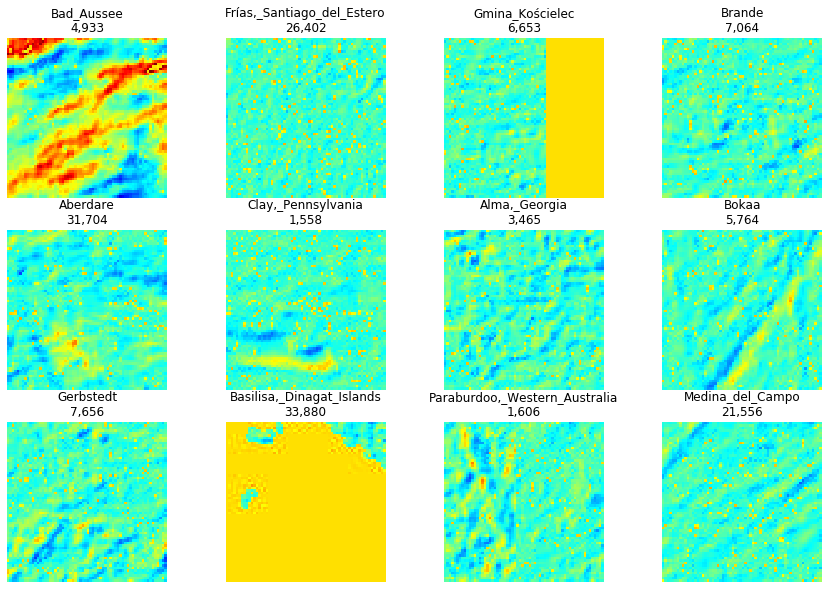

In [4]:
# CELL 4
import random
import cv2
import numpy as np
PARAM_DATA_PATH='./boxes'

dev_uris = set()
pop = dict()
with open("ch6_cell32_dev_feat_conservative.tsv") as f:
    next(f) # header
    for line in f:
        fields = line.strip().split("\t")
        dev_uris.add(fields[0])
        pop[fields[0]] = fields[-1]

cities = list()
with open("ch9_cell1_cities1000_gps.tsv") as f:
    next(f) # header
    for line in f:
        uri, geoid, lat, lon = line.split("\t")
        if uri in dev_uris:
            cities.append( (uri, geoid, float(lat), float(lon)) )

rand = random.Random(42)
rand.shuffle(cities)

from matplotlib import pyplot as plt
%matplotlib inline


plt.rcParams['figure.figsize'] = [15, 10]

for idx, row in enumerate(cities[:4]):
    uri, geoid, lat, lon = row
    name = uri.split("/")[-1][:-1]
    plt.subplot(1,4, idx+1)
    img = cv2.imread("{}/{}.png".format(PARAM_DATA_PATH, geoid))
    plt.imshow(img)
    plt.axis('off')
    plt.title("{}\n{:,}".format(name, int(10**float(pop[uri]))))
plt.savefig("ch9_cell4_eda1.pdf", bbox_inches='tight', dpi=300)

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]


for idx, row in enumerate(cities[:12]):
    uri, geoid, lat, lon = row
    name = uri.split("/")[-1][:-1]
    plt.subplot(3,4, idx+1)
    img = cv2.imread("{}/{}.png".format(PARAM_DATA_PATH, geoid))
    img2 = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    plt.imshow(img2)
    plt.axis('off')
    plt.title("{}\n{:,}".format(name, int(10**float(pop[uri]))))
plt.show()

We can see that places with more mountains have less population. Let's take a look at the histograms in Cell #5.

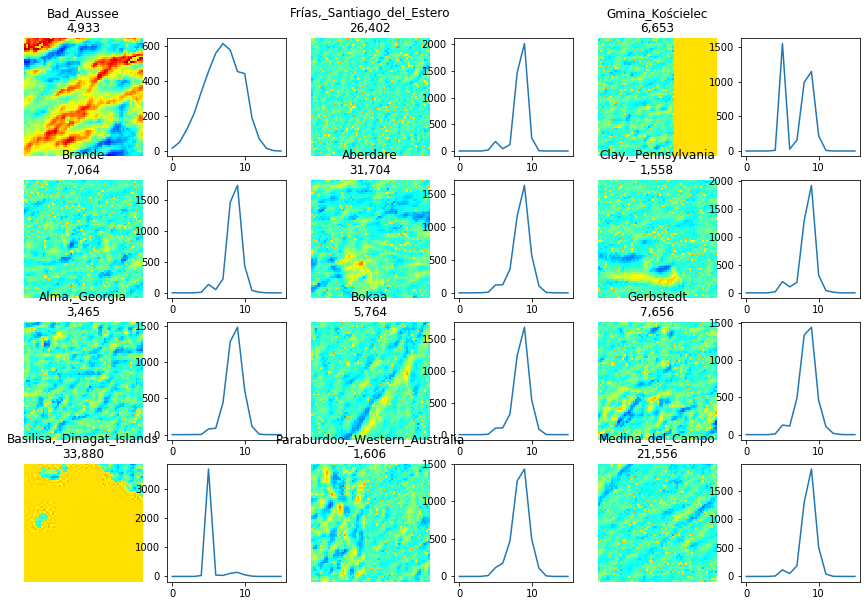

In [5]:
# CELL 5
import random
import cv2
import numpy as np
PARAM_DATA_PATH='./boxes'

dev_uris = set()
pop = dict()
with open("ch6_cell32_dev_feat_conservative.tsv") as f:
    next(f) # header
    for line in f:
        fields = line.strip().split("\t")
        dev_uris.add(fields[0])
        pop[fields[0]] = fields[-1]

cities = list()
with open("ch9_cell1_cities1000_gps.tsv") as f:
    next(f) # header
    for line in f:
        uri, geoid, lat, lon = line.split("\t")
        if uri in dev_uris:
            cities.append( (uri, geoid, float(lat), float(lon)) )

rand = random.Random(42)
rand.shuffle(cities)

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

for idx, row in enumerate(cities[:4]):
    uri, geoid, lat, lon = row
    name = uri.split("/")[-1][:-1]
    plt.subplot(2, 4, idx + 1)
    img = cv2.imread("{}/{}.png".format(PARAM_DATA_PATH, geoid))
    plt.imshow(img)
    plt.axis('off')
    plt.title("{}\n{:,}".format(name, int(10**float(pop[uri]))))
    plt.subplot(2, 4, idx + 5)
    plt.plot(cv2.calcHist([img], [0],None,[16],[0,256]))
plt.savefig("ch9_cell5_eda_hist.pdf", bbox_inches='tight', dpi=300)

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]


for idx, row in enumerate(cities[:12]):
    uri, geoid, lat, lon = row
    name = uri.split("/")[-1][:-1]
    plt.subplot(4,6, 2*idx + 1)
    img = cv2.imread("{}/{}.png".format(PARAM_DATA_PATH, geoid))
    img2 = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    plt.imshow(img2)
    plt.axis('off')
    plt.title("{}\n{:,}".format(name, int(10**float(pop[uri]))))
    plt.subplot(4, 6, 2*idx+2)
    plt.plot(cv2.calcHist([img], [0],None,[16],[0,256]))

plt.show()

We are ready to try ML using all pixels as features.

## First Featurization

Using each pixel as a feature for $32\times 32$ expands the feature vector in 1,024 features, which with the 98 original ends up in 1,122 (Cell #6).

Read 0 out of 44,959
Read 8,991 out of 44,959
Read 17,982 out of 44,959
Read 26,973 out of 44,959
Read 35,964 out of 44,959
Read 44,955 out of 44,959
Wrote 0 out of 44,959
Wrote 8,991 out of 44,959
Wrote 17,982 out of 44,959
Wrote 26,973 out of 44,959
Wrote 35,964 out of 44,959
Wrote 44,955 out of 44,959
Training on 35,971 cities
using 1,122 features
Baseline training took 19.819483757019043 seconds
Baseline RMSE 0.31895350002111916
Training took 1,123.1410493850708 seconds
RMSE 0.3434484570101145
Writing files for error analysis


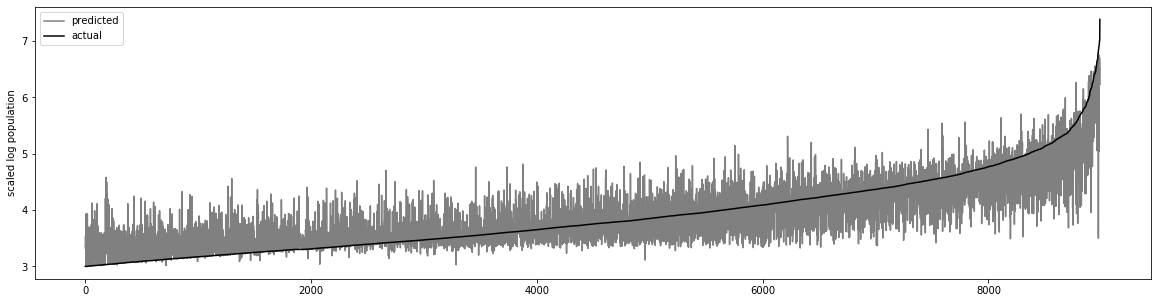

In [6]:
# CELL 6
import math
import random
import cv2
import numpy as np
import time
from sklearn.ensemble import RandomForestRegressor
PARAM_DATA_PATH='./boxes'

header = None
data = list()
with open("ch6_cell32_dev_feat_conservative.tsv") as f:
    header = next(f)
    header = header.strip().split('\t')
    for line in f:
        fields = line.strip().split("\t")
        name = fields.pop(0)
        logpop = float(fields[-1])
        feats = list(map(float, fields[:-1]))
        row = (feats, logpop, name)
        data.append(row)

uri_to_geoid = dict()
with open("ch6_cell1_cities1000_links.ttl") as f:
    for line in f:
        fields = line.split(' ')
        _id = fields[2]
        _id = _id.split('/')[-2]
        uri_to_geoid[fields[0]] = _id

header = list(header[:-1]) + [ fname for rowlist in map(lambda x: map(lambda y:"p-{}-{}".format(x,y), 
                                                                      range(32)), range(32))
                              for fname in rowlist ] + [ header[-1] ]
for idx, row in enumerate(data):
    if idx % (len(data) // 5) == 0:
        print("Read {:,} out of {:,}".format(idx, len(data)))
    feats, _, name = row
    img = cv2.imread("{}/{}.png".format(PARAM_DATA_PATH, uri_to_geoid[name]))
    r, _, _ = cv2.split(img)
    feats.extend(r[16:48,16:48].reshape(-1))
    data[idx] = (np.array(feats), row[1], row[2])    

# write full file
with open("ch9_cell6_dev_feat1.tsv",  "w") as f:
    f.write("\t".join(header) + '\n')
    for idx, row in enumerate(data):
        if idx % (len(data) // 5) == 0:
            print("Wrote {:,} out of {:,}".format(idx, len(data)))
        feats, logpop, name = row
        f.write("{}\t{}\t{}\n".format(name, "\t".join(map(lambda x: str(int(x)) if int(x) == x else str(x),
                                                          feats)), logpop))
        
train_data = list()
test_data = list()
rand = random.Random(42)
for row in data:
    if rand.random() < 0.2:
        test_data.append(row) 
    else:
        train_data.append(row)
data=None
               
train_names = list(map(lambda t:t[2], train_data))

test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest = np.array(list(map(lambda t:t[0], test_data)))
ytest = np.array(list(map(lambda t:t[1], test_data)))
train_data=None
test_data=None

# train RF
print("Training on {:,} cities\nusing {:,} features".format(*xtrain.shape))

start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain[:,:98], ytrain)
print("Baseline training took {:,} seconds".format(time.time() - start))
ytest_pred = rfr.predict(xtest[:,:98])
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("Baseline RMSE", RMSE)

start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain, ytrain)
print("Training took {:,} seconds".format(time.time() - start))
ytest_pred = rfr.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

print("Writing files for error analysis")
np.savez_compressed("ch9_cell6_feat1_rf.npz", 
                    xtrain=xtrain, ytrain=ytrain,
                    xtest=xtest, ytest=ytest,
                    ytest_pred=ytest_pred)
import pickle
with open("ch9_cell6_model.pk", "wb") as pkl:
    pickle.dump(rfr, pkl)
with open("ch9_cell6_test_names.tsv", "w") as names:
    for idx, name in enumerate(test_names):
        names.write("{}\t{}\n".format(idx, name))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch9_cell6_rf_feat1.pdf", bbox_inches='tight', dpi=300)
plt.legend()

That did not work very well, we're better off without the image features. Let's start by doing some visualization of the importance of the new features (Cell #7).

Maximum importance for non-pixel features 0.2270277171305718
Mean importance    for non-pixel features 0.007753290939281302
Maximum importance for pixel     features 0.00037305373851944003
Mean importance    for pixel     features 0.00023454832807659416


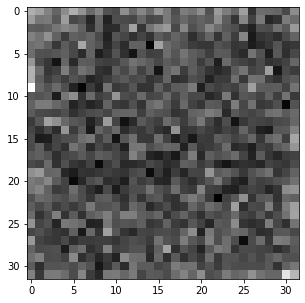

In [7]:
# CELL 7
import pickle
import math
import cv2

def cell7_model_to_image(model_file, feature_file):
    # get model
    rfr = None
    with open(model_file, "rb") as pkl:
        rfr = pickle.load(pkl)

    # get feature names
    header = None
    with open(feature_file) as f:
        header = next(f)
        header = header.strip().split('\t')
        header.pop() # population
        header.pop(0) # name

    first_pixel = list(filter(lambda x:x[1].startswith("p-"), enumerate(header)))[0][0]
    side = int(math.sqrt(len(header) - first_pixel))
    print("Maximum importance for non-pixel features", rfr.feature_importances_[:first_pixel].max())
    print("Mean importance    for non-pixel features", rfr.feature_importances_[:first_pixel].mean())
    print("Maximum importance for pixel     features", rfr.feature_importances_[first_pixel:].max())
    print("Mean importance    for pixel     features", rfr.feature_importances_[first_pixel:].mean())

    importances = rfr.feature_importances_[first_pixel:].copy()
    min_i = importances.min()
    max_i = importances.max()
    importances -= min_i
    importances /= (max_i - min_i)
    importances_copy = importances.copy()

    img = importances_copy.reshape( (side, side) )
    img *= 255
    img = img.astype('uint8')
    img2 = cv2.merge( [img, img, img] )
    return img2

img = cell7_model_to_image("ch9_cell6_model.pk", "ch9_cell6_dev_feat1.tsv")

from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(img, aspect='equal')
plt.savefig("ch9_cell7_rf_feat_importance.pdf", bbox_inches='tight', dpi=300)

The feature importance shows the system is not caring much about the pixels nor any specific one neither. Let's try adding some Gaussian blur to smooth the data (Cell #8).

Read 0 out of 44,959
Read 8,991 out of 44,959
Read 17,982 out of 44,959
Read 26,973 out of 44,959
Read 35,964 out of 44,959
Read 44,955 out of 44,959
Wrote 0 out of 44,959
Wrote 8,991 out of 44,959
Wrote 17,982 out of 44,959
Wrote 26,973 out of 44,959
Wrote 35,964 out of 44,959
Wrote 44,955 out of 44,959
Training on 35,971 cities
using 1,122 features
Baseline training took 19.608769416809082 seconds
Baseline RMSE 0.31895350002111916
Training took 1,048.8585846424103 seconds
RMSE 0.340798195202612
Writing files for error analysis


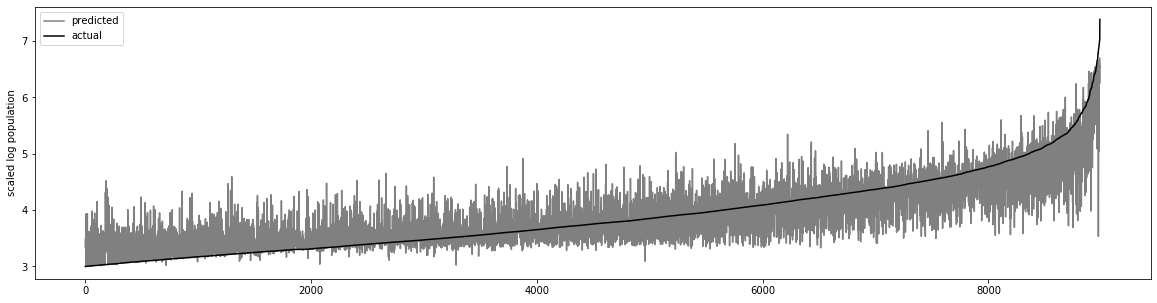

In [8]:
# CELL 8
import math
import random
import cv2
import numpy as np
import time
from sklearn.ensemble import RandomForestRegressor
PARAM_DATA_PATH='./boxes'

header = None
data = list()
with open("ch6_cell32_dev_feat_conservative.tsv") as f:
    header = next(f)
    header = header.strip().split('\t')
    for line in f:
        fields = line.strip().split("\t")
        name = fields.pop(0)
        logpop = float(fields[-1])
        feats = list(map(float, fields[:-1]))
        row = (feats, logpop, name)
        data.append(row)

uri_to_geoid = dict()
with open("ch6_cell1_cities1000_links.ttl") as f:
    for line in f:
        fields = line.split(' ')
        _id = fields[2]
        _id = _id.split('/')[-2]
        uri_to_geoid[fields[0]] = _id

header = list(header[:-1]) + [ fname for rowlist in map(lambda x: map(lambda y:"p-{}-{}".format(x,y), 
                                                                      range(32)), range(32))
                              for fname in rowlist ] + [ header[-1] ]
for idx, row in enumerate(data):
    if idx % (len(data) // 5) == 0:
        print("Read {:,} out of {:,}".format(idx, len(data)))
    feats, _, name = row
    img = cv2.imread("{}/{}.png".format(PARAM_DATA_PATH, uri_to_geoid[name]))
    img = cv2.GaussianBlur(img, (3,3), 0)
    r, _, _ = cv2.split(img)
    feats.extend(r[16:48,16:48].reshape(-1))
    data[idx] = (np.array(feats), row[1], row[2])    

# write full file
with open("ch9_cell8_dev_feat1_gauss.tsv",  "w") as f:
    f.write("\t".join(header) + '\n')
    for idx, row in enumerate(data):
        if idx % (len(data) // 5) == 0:
            print("Wrote {:,} out of {:,}".format(idx, len(data)))
        feats, logpop, name = row
        f.write("{}\t{}\t{}\n".format(name, "\t".join(map(lambda x: str(int(x)) if int(x) == x else str(x),
                                                          feats)), logpop))
        
train_data = list()
test_data = list()
rand = random.Random(42)
for row in data:
    if rand.random() < 0.2:
        test_data.append(row) 
    else:
        train_data.append(row)
data=None
               
train_names = list(map(lambda t:t[2], train_data))

test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))
train_names = list(map(lambda t:t[2], train_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest = np.array(list(map(lambda t:t[0], test_data)))
ytest = np.array(list(map(lambda t:t[1], test_data)))
train_data=None
test_data=None

# train RF
print("Training on {:,} cities\nusing {:,} features".format(*xtrain.shape))

start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain[:,:98], ytrain)
print("Baseline training took {:,} seconds".format(time.time() - start))
ytest_pred = rfr.predict(xtest[:,:98])
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("Baseline RMSE", RMSE)

start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain, ytrain)
print("Training took {:,} seconds".format(time.time() - start))
ytest_pred = rfr.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

print("Writing files for error analysis")
np.savez_compressed("ch9_cell8_feat1_gauss_rf.npz", 
                    xtrain=xtrain, ytrain=ytrain,
                    xtest=xtest, ytest=ytest,
                    ytest_pred=ytest_pred)
import pickle
with open("ch9_cell8_model.pk", "wb") as pkl:
    pickle.dump(rfr, pkl)
with open("ch9_cell8_train_names.tsv", "w") as names:
    for idx, name in enumerate(train_names):
        names.write("{}\t{}\n".format(idx, name))
with open("ch9_cell8_test_names.tsv", "w") as names:
    for idx, name in enumerate(test_names):
        names.write("{}\t{}\n".format(idx, name))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch9_cell8_rf_feat1_gauss.pdf", bbox_inches='tight', dpi=300)
plt.legend()

There was a tiny improvement. Visualizing feature importance again Cell #9.

Maximum importance for non-pixel features 0.2271961323378289
Mean importance    for non-pixel features 0.007835081495580315
Maximum importance for pixel     features 0.00042086643504834554
Mean importance    for pixel     features 0.00022672071624329042


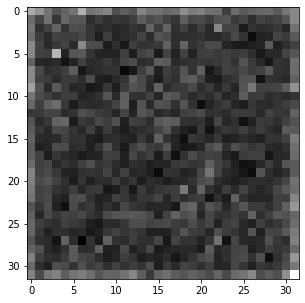

In [9]:
# CELL 9
img = cell7_model_to_image("ch9_cell8_model.pk", "ch9_cell8_dev_feat1_gauss.tsv")

from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(img, aspect='equal')
plt.savefig("ch9_cell9_rf_feat_importance.pdf", bbox_inches='tight', dpi=300)

That did help a tiny bit and the weights look quite differente.

The other piece of advice is to whiten the data, let's try that (Cell #10).

Base size 98
Read 0 out of 44,959
Read 8,991 out of 44,959
Read 17,982 out of 44,959
Read 26,973 out of 44,959
Read 35,964 out of 44,959
Read 44,955 out of 44,959
Wrote 0 out of 35,971
Wrote 7,194 out of 35,971
Wrote 14,388 out of 35,971
Wrote 21,582 out of 35,971
Wrote 28,776 out of 35,971
Wrote 35,970 out of 35,971
Wrote 0 out of 8,988
Wrote 1,797 out of 8,988
Wrote 3,594 out of 8,988
Wrote 5,391 out of 8,988
Wrote 7,188 out of 8,988
Wrote 8,985 out of 8,988
Training on 35,971 cities
using 1,122 features
Baseline training took 19.62180995941162 seconds
Baseline RMSE 0.3189535000211191
Training took 1,843.5154190063477 seconds
RMSE 0.3476486854059412
Writing files for error analysis


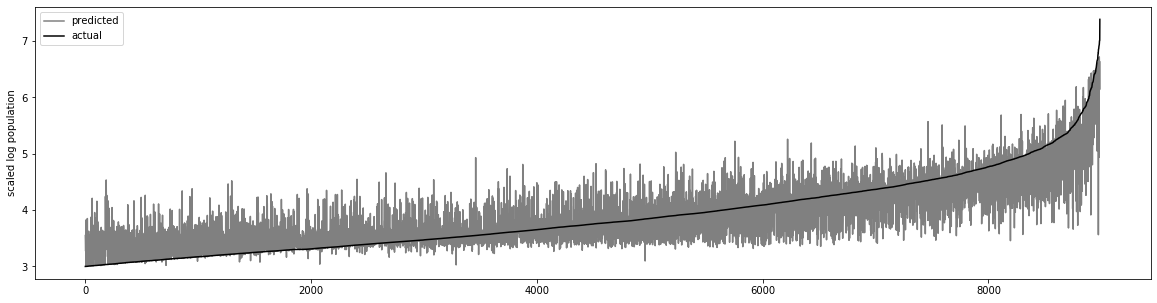

In [10]:
# CELL 10
import math
import random
import cv2
import numpy as np
import time
from sklearn.ensemble import RandomForestRegressor
PARAM_DATA_PATH='./boxes'

header = None
data   = list()
with open("ch6_cell32_dev_feat_conservative.tsv") as f:
    header = next(f)
    header = header.strip().split('\t')
    for line in f:
        fields = line.strip().split("\t")
        name   = fields.pop(0)
        logpop = float(fields[-1])
        feats  = list(map(float, fields[:-1]))
        row    = (feats, logpop, name)
        data.append(row)

uri_to_geoid = dict()
with open("ch6_cell1_cities1000_links.ttl") as f:
    for line in f:
        fields = line.split(' ')
        _id = fields[2]
        _id = _id.split('/')[-2]
        uri_to_geoid[fields[0]] = _id

base_size = len(header) - 2
print("Base size", base_size)
header = list(header[:-1]) + [ fname for rowlist in map(lambda x: map(lambda y:"p-{}-{}".format(x,y), 
                                                                      range(32)), range(32))
                              for fname in rowlist ] + [ header[-1] ]
for idx, row in enumerate(data):
    if idx % (len(data) // 5) == 0:
        print("Read {:,} out of {:,}".format(idx, len(data)))
    feats, _, name = row
    img = cv2.imread("{}/{}.png".format(PARAM_DATA_PATH, uri_to_geoid[name]))
    img = cv2.GaussianBlur(img, (3,3), 0)
    r, _, _ = cv2.split(img)
    feats.extend(r[16:48,16:48].reshape(-1))
    data[idx] = (np.array(feats), row[1], row[2])    
       
train_data = list()
test_data  = list()
rand = random.Random(42)
for row in data:
    if rand.random() < 0.2:
        test_data.append(row) 
    else:
        train_data.append(row)
data = None
               
train_names = list(map(lambda t:t[2], train_data))

test_data   = sorted(test_data, key=lambda t:t[1])
test_names  = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))
train_data = None
test_data  = None

xtrain_orig = xtrain.copy()
xtest_orig  = xtest.copy()

# normalize
xtrain[:,base_size:] = xtrain[:,base_size:] / 256.0
xtest[:, base_size:] = xtest[:, base_size:] / 256.0

# centre images
means = np.mean(xtrain[:, base_size:], axis=0)
xtrain[:,base_size:] = xtrain[:,base_size:] - means
xtest[:, base_size:] = xtest[:, base_size:] - means

# compute whiten transform
covar   = np.dot(xtrain[:, base_size:].T, xtrain[:, base_size:]) / xtrain.shape[0]
E, D, _ = np.linalg.svd(covar) # PCA
#eps = 0.1 # Pal & Sudeep (2016)
eps   = 0.001
D_inv = 1. / np.sqrt(D[np.newaxis] + eps)
zca = (E * D_inv).dot(E.T)

#pca_whiten = np.dot(np.diag(1.0 / np.sqrt(D + eps)), E.T)
#zca = np.dot(E, pca_whiten)
#zca = np.dot(E, np.dot(np.diag(1.0 / np.sqrt(D + eps)), E.T))
whitened_train       = np.dot(xtrain[:, base_size:], zca)
xtrain[:,base_size:] = whitened_train

whitened_test        = np.dot(xtest[:, base_size:], zca)
xtest[:, base_size:] = whitened_test
    
# write full file
with open("ch9_cell10_dev_feat1_whiten.tsv",  "w") as f:
    f.write("\t".join(header) + '\n')
    for idx in range(xtrain.shape[0]):
        if idx % (xtrain.shape[0] // 5) == 0:
            print("Wrote {:,} out of {:,}".format(idx, xtrain.shape[0]))
        # different versions of python seem to print differently just using str
        f.write("{}\t{}\t{}\n".format(train_names[idx], 
                                      "\t".join(map(lambda x: str(int(x)) if int(x) == x else "{:0.12f}".format(x),
                                                          xtrain[idx,:])), ytrain[idx]))
    for idx in range(xtest.shape[0]):
        if idx % (xtest.shape[0] // 5) == 0:
            print("Wrote {:,} out of {:,}".format(idx, xtest.shape[0]))
        f.write("{}\t{}\t{}\n".format(test_names[idx], 
                                      "\t".join(map(lambda x: str(int(x)) if int(x) == x else "{:0.12f}".format(x),
                                                          xtest[idx,:])), ytest[idx]))

# train RF
print("Training on {:,} cities\nusing {:,} features".format(*xtrain.shape))

start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain[:,:base_size], ytrain)
print("Baseline training took {:,} seconds".format(time.time() - start))
ytest_pred = rfr.predict(xtest[:,:base_size])
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("Baseline RMSE", RMSE)

start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain, ytrain)
print("Training took {:,} seconds".format(time.time() - start))
ytest_pred = rfr.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

print("Writing files for error analysis")
np.savez_compressed("ch9_cell10_feat1_whiten_rf.npz", 
                    xtrain=xtrain,           ytrain=ytrain,
                    xtrain_orig=xtrain_orig, xtest_orig=xtest_orig,
                    xtest=xtest,             ytest=ytest,
                    ytest_pred=ytest_pred)
import pickle
with open("ch9_cell10_model.pk", "wb") as pkl:
    pickle.dump(rfr, pkl)
with open("ch9_cell8_test_names.tsv", "w") as names:
    for idx, name in enumerate(test_names):
        names.write("{}\t{}\n".format(idx, name))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch9_cell10_rf_feat1_whiten.pdf", bbox_inches='tight', dpi=300)
plt.legend()

That was bad but not as bad as when I forgot to centre and normalize (0.47 RMSE).

Let us see if the ZCA achieved zero correlation and means (Cell #11)

In [11]:
# CELL 11
import numpy as np

loaded = np.load("ch9_cell10_feat1_whiten_rf.npz")
xtrain=loaded['xtrain']

# get feature names
header = None
with open("ch9_cell8_dev_feat1_gauss.tsv") as f:
    header = next(f)
    header = header.strip().split('\t')
    header.pop() # population
    header.pop(0) # name

base_size = list(filter(lambda x:x[1].startswith("p-"), enumerate(header)))[0][0]

covar=np.dot(xtrain[:, base_size:].T, xtrain[:, base_size:]) / xtrain.shape[0]
print("trace ", covar.trace())
print("excess", covar.sum()-covar.trace())
mean = np.mean(xtrain[:, base_size:], axis=0)
print("means ", sum(mean))
print(sum(map(np.std,map(lambda x:xtrain[:, base_size+x], range(xtrain.shape[1] - base_size)))))

trace  232.2074966460317
excess 791.4456602161645
means  -2.6874387835913965e-15
486.6979639394406


Now let's try to visualize whether any of the available information is still visible there (the big advantage of ZCA), Cell #12

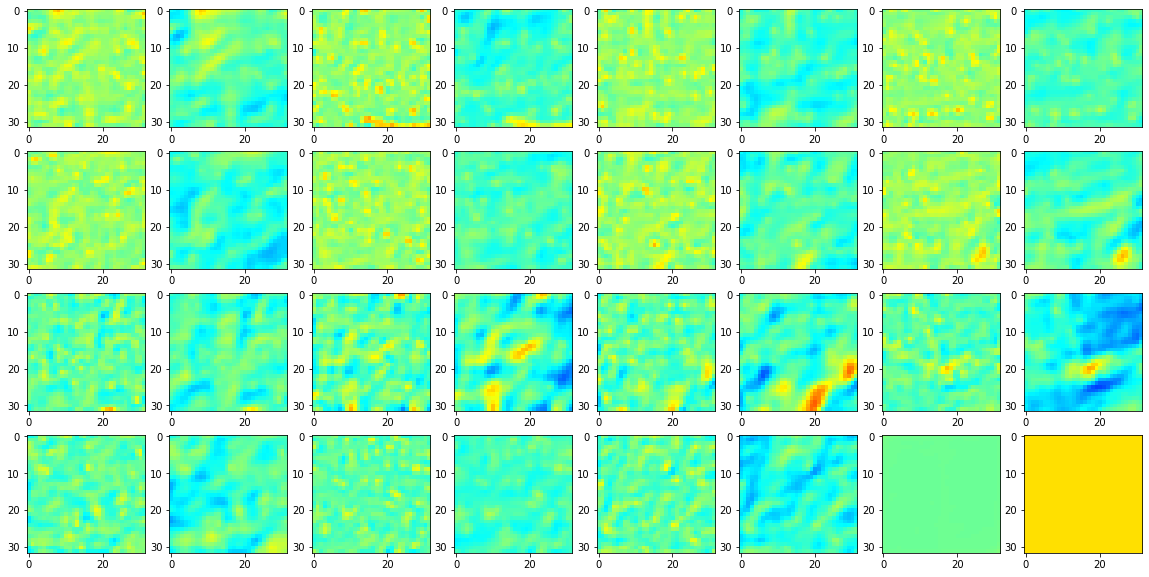

In [12]:
# CELL 12
import numpy as np

loaded = np.load("ch9_cell10_feat1_whiten_rf.npz")
xtrain=loaded['xtrain']
xtest=loaded['xtest']
xtrain_orig=loaded['xtrain_orig']
xtest_orig=loaded['xtest_orig']

# get feature names
header = None
with open("ch9_cell8_dev_feat1_gauss.tsv") as f:
    header = next(f)
    header = header.strip().split('\t')
    header.pop() # population
    header.pop(0) # name

base_size = list(filter(lambda x:x[1].startswith("p-"), enumerate(header)))[0][0]
side = int(math.sqrt(len(header) - base_size))

zca_rescaled = (xtrain[:,base_size:] - xtrain[:,base_size:].min()) / (xtrain[:,base_size:].max() - xtrain[:,base_size:].min())
zca_rescaled_test = (xtest[:,base_size:] - xtest[:,base_size:].min()) / (xtest[:,base_size:].max() - xtest[:,base_size:].min())

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

for idx in range(4):
    plt.subplot(4,4,2*idx + 1)
    img  = zca_rescaled[idx].reshape( (side,side) ).copy()
    img *= 256
    img  = img.astype('uint8')
    plt.imshow(cv2.merge( [img, img, img] ))
    plt.subplot(4,4,2*idx + 2)
    img = xtrain_orig[idx,base_size:].reshape( (side,side) ).astype('uint8')
    plt.imshow(cv2.merge( [img, img, img] ))
for idx in range(4):
    plt.subplot(4,4,2*(idx+4) + 1)
    img  = zca_rescaled_test[idx].reshape( (side,side) ).copy()
    img *= 256
    img  = img.astype('uint8')
    plt.imshow(cv2.merge( [img, img, img] ))
    plt.subplot(4,4,2*(idx+4) + 2)
    img = xtest_orig[idx,base_size:].reshape( (side,side) ).astype('uint8')
    plt.imshow(cv2.merge( [img, img, img] ))
plt.savefig("ch9_cell12_whiten.pdf", bbox_inches='tight', dpi=300)


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

for idx in range(8):
    plt.subplot(4,8,2*idx + 1)
    img = zca_rescaled[idx].reshape( (side,side) ).copy()
    img *= 256
    img = img.astype('uint8')
    img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    plt.imshow(img)
    plt.subplot(4,8,2*idx + 2)
    img = xtrain_orig[idx,base_size:].reshape( (side,side) ).astype('uint8')
    img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    plt.imshow(img)
for idx in range(8):
    plt.subplot(4,8,2*(idx+8) + 1)
    img = zca_rescaled_test[idx].reshape( (side,side) ).copy()
    img *= 256
    img = img.astype('uint8')
    img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    plt.imshow(img)
    plt.subplot(4,8,2*(idx+8) + 2)
    img = xtest_orig[idx,base_size:].reshape( (side,side) ).astype('uint8')
    img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    plt.imshow(img)

And now to visualize the model (Cell #11).

Maximum importance for non-pixel features 0.22666379312596627
Mean importance    for non-pixel features 0.007658611922275058
Maximum importance for pixel     features 0.00041288581450650525
Mean importance    for pixel     features 0.0002436094058760198


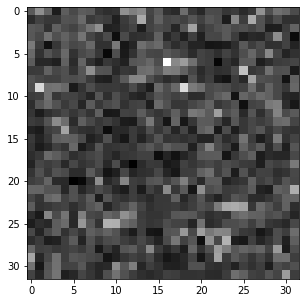

In [13]:
# CELL 13
import pickle
import math

img = cell7_model_to_image("ch9_cell10_model.pk", "ch9_cell10_dev_feat1_whiten.tsv")

from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(img, aspect='equal')
plt.savefig("ch9_cell13_rf_feat_importance.pdf", bbox_inches='tight', dpi=300)

Now let's go back to the Gauss format that worked well and see whether doing a variation might help (Cell #14).
To avoid overfitting, I'll re-train a RF on a subset of the training, then we'll see what transformation on the source data achieves better results.

In [14]:
# CELL 14
import math
import random
import time
import pickle
from collections import OrderedDict

import cv2
import numpy as np
from sklearn.ensemble import RandomForestRegressor

PARAM_DATA_PATH='./boxes'

loaded = np.load("ch9_cell8_feat1_gauss_rf.npz")
xtrain = loaded['xtrain']
ytrain = loaded['ytrain']
                  
# get feature names
header = None
with open("ch9_cell8_dev_feat1_gauss.tsv") as f:
    header = next(f)
    header = header.strip().split('\t')
    header.pop() # population
    header.pop(0) # name

base_size = list(filter(lambda x:x[1].startswith("p-"), enumerate(header)))[0][0]
side = int(math.sqrt(len(header) - base_size))
train_size = int(xtrain.shape[0] * 0.8)

# get train names
train_names = list()
with open("ch9_cell8_train_names.tsv") as f:
    for line in f:
        train_names.append(line.strip().split('\t')[-1])
        
# geoids
uri_to_geoid = dict()
with open("ch6_cell1_cities1000_links.ttl") as f:
    for line in f:
        fields = line.split(' ')
        _id = fields[2]
        _id = _id.split('/')[-2]
        uri_to_geoid[fields[0]] = _id

# train the RF on the top 80% of the training data
print("Training on {:,} cities\nusing {:,} features".format(*xtrain[:train_size,:].shape))

PARAM_RETRAIN = True
if PARAM_RETRAIN:
    start = time.time()
    rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
    rfr.fit(xtrain[:train_size,:], ytrain[:train_size])
    with open("ch9_cell14_model.pk", "wb") as pkl:
        pickle.dump(rfr, pkl)
    print("Training took {:,} seconds".format(time.time() - start))
else:
    rfr = None
    with open("ch9_cell14_model.pk", "rb") as pkl:
        rfr = pickle.load(pkl)

ytrain_pred = rfr.predict(xtrain[train_size:,:])
RMSE = math.sqrt(sum((ytrain[train_size:] - ytrain_pred)**2) / len(ytrain_pred))
print("RMSE", RMSE)

improved      = OrderedDict()
improved_perc = OrderedDict()
exp  = 0
imgs = 0
rand = random.Random(42)
for idx in range(ytrain_pred.shape[0]):
    if idx % (ytrain_pred.shape[0] // 5) == 0:
        print("Row {:,} out of {:,} ({:,}), total experiments so far {:,}"
              .format(idx, ytrain_pred.shape[0], imgs, exp))
    if rand.random() > 0.2:
        continue
    imgs += 1
    target = ytrain[train_size + idx]
    baseline = (target - ytrain_pred[idx])**2
    baseline_perc = baseline * 0.5
    
    # get original 64x64 box
    name = train_names[train_size + idx]
    expanded = cv2.imread("{}/{}.png".format(PARAM_DATA_PATH, uri_to_geoid[name]))
    eside = expanded.shape[0]
    ecentre = eside // 2
    centre = side // 2

    orig = xtrain[train_size + idx,:]
    row = orig.copy().reshape( (1, -1) )
    
    # scale
    for dsize in range(-10,10):
        if dsize == 0 or rand.random() > 0.1:
            continue
        new_ecentre = (eside + dsize) // 2
        # x
        cond = 'xscale={}'.format(dsize)
        img = cv2.resize(expanded, (eside + dsize, eside), interpolation=cv2.INTER_CUBIC)
        img, _, _ = cv2.split(img)
        row[0][base_size:] = img[(new_ecentre - centre):(new_ecentre + centre),
                                 (ecentre - centre):(ecentre+centre)].reshape(-1)
        pred = rfr.predict(row)[0]
        exp += 1
        if (target - pred)**2 < baseline:
            improved[cond] = improved.get(cond, 0) + 1
            if (target - pred)**2 < baseline_perc:
                improved_perc[cond] = improved_perc.get(cond, 0) + 1
        # y
        cond = 'yscale={}'.format(dsize)
        img = cv2.resize(expanded, (eside, eside  + dsize), interpolation=cv2.INTER_CUBIC)
        img, _, _ = cv2.split(img)
        row[0][base_size:] = img[(ecentre - centre):(ecentre + centre),
                                 (new_ecentre - centre):(new_ecentre+centre)].reshape(-1)
        pred = rfr.predict(row)[0]
        exp += 1
        if (target - pred)**2 < baseline:
            improved[cond] = improved.get(cond, 0) + 1
            if (target - pred)**2 < baseline_perc:
                improved_perc[cond] = improved_perc.get(cond, 0) + 1
            
    # translate
    for delta in range(-10,10):
        if delta == 0  or rand.random() > 0.1:
            continue
        # x
        cond = 'xtrans={}'.format(delta)
        matrix = np.float32([[1,0,delta], [0,1,0]])
        img = cv2.warpAffine(expanded, matrix, (eside, eside) )
        img, _, _ = cv2.split(img)
        row[0][base_size:] = img[(ecentre - centre):(ecentre + centre),
                                 (ecentre - centre):(ecentre+centre)].reshape(-1)
        pred = rfr.predict(row)[0]
        exp += 1
        if (target - pred)**2 < baseline:
            improved[cond] = improved.get(cond, 0) + 1
            if (target - pred)**2 < baseline_perc:
                improved_perc[cond] = improved_perc.get(cond, 0) + 1
        # y
        cond = 'ytrans={}'.format(delta)
        matrix = np.float32([[1,0,0], [0,1,delta]])
        img = cv2.warpAffine(expanded, matrix, (eside, eside) )
        img, _, _ = cv2.split(img)
        row[0][base_size:] = img[(ecentre - centre):(ecentre + centre),
                                 (ecentre - centre):(ecentre + centre)].reshape(-1)
        pred = rfr.predict(row)[0]
        exp += 1
        if (target - pred)**2 < baseline:
            improved[cond] = improved.get(cond, 0) + 1
            if (target - pred)**2 < baseline_perc:
                improved_perc[cond] = improved_perc.get(cond, 0) + 1
    
    # rotate
    for angle in range(1, 18):
        if rand.random() > 0.1:
            continue
        cond = 'rot={}'.format(angle * 20)
        matrix = cv2.getRotationMatrix2D((ecentre, ecentre),angle*20, 1)
        img = cv2.warpAffine(expanded, matrix, (eside, eside) ) 
        img, _, _ = cv2.split(img)
        row[0][base_size:] = img[(ecentre - centre):(ecentre + centre),
                                 (ecentre - centre):(ecentre + centre)].reshape(-1)
        pred = rfr.predict(row)[0]
        exp += 1
        if (target - pred)**2 < baseline:
            improved[cond] = improved.get(cond, 0) + 1
            if (target - pred)**2 < baseline_perc:
                improved_perc[cond] = improved_perc.get(cond, 0) + 1

with open("ch9_cell14_improvements.tsv", "w") as f:
    f.write("condition\tparam\tcount\n")
    for key, value in improved.items():
        cond, param = key.split("=")
        f.write("{}\t{}\t{}\n".format(cond, param, value))
with open("ch9_cell14_improvements_perc.tsv", "w") as f:
    f.write("condition\tparam\tcount\n")
    for key, value in improved_perc.items():
        cond, param = key.split("=")
        f.write("{}\t{}\t{}\n".format(cond, param, value))

print("Total experiments    ", exp)
print("Total improvements   ", sum(improved.values()))
print("Total improvement 50%", sum(improved_perc.values()))
conditions = set(map(lambda x:x.split("=")[0],improved.keys()))
for condition in sorted(conditions):
    accum = 0
    accum_perc = 0
    for key, value in improved.items():
        if key.split("=")[0] == condition:
            accum += value
    for key, value in improved_perc.items():
        if key.split("=")[0] == condition:
            accum_perc += value
    print("Total for {}: {:,}     improvements".format(condition, accum))
    print("Total for {}: {:,} 50% improvements".format(condition, accum_perc))


Training on 28,776 cities
using 1,122 features
Training took 808.3796174526215 seconds
RMSE 0.3498677500106264
Row 0 out of 7,195 (0), total experiments so far 0
Row 1,439 out of 7,195 (307), total experiments so far 2,803
Row 2,878 out of 7,195 (578), total experiments so far 5,323
Row 4,317 out of 7,195 (862), total experiments so far 8,032
Row 5,756 out of 7,195 (1,167), total experiments so far 10,938
Total experiments     13649
Total improvements    6078
Total improvement 50% 1777
Total for rot: 1,191     improvements
Total for rot: 391 50% improvements
Total for xscale: 1,241     improvements
Total for xscale: 363 50% improvements
Total for xtrans: 1,198     improvements
Total for xtrans: 321 50% improvements
Total for yscale: 1,237     improvements
Total for yscale: 341 50% improvements
Total for ytrans: 1,211     improvements
Total for ytrans: 361 50% improvements


Let's see the distribution of the parameters that helped improve 50% (Cell #15)

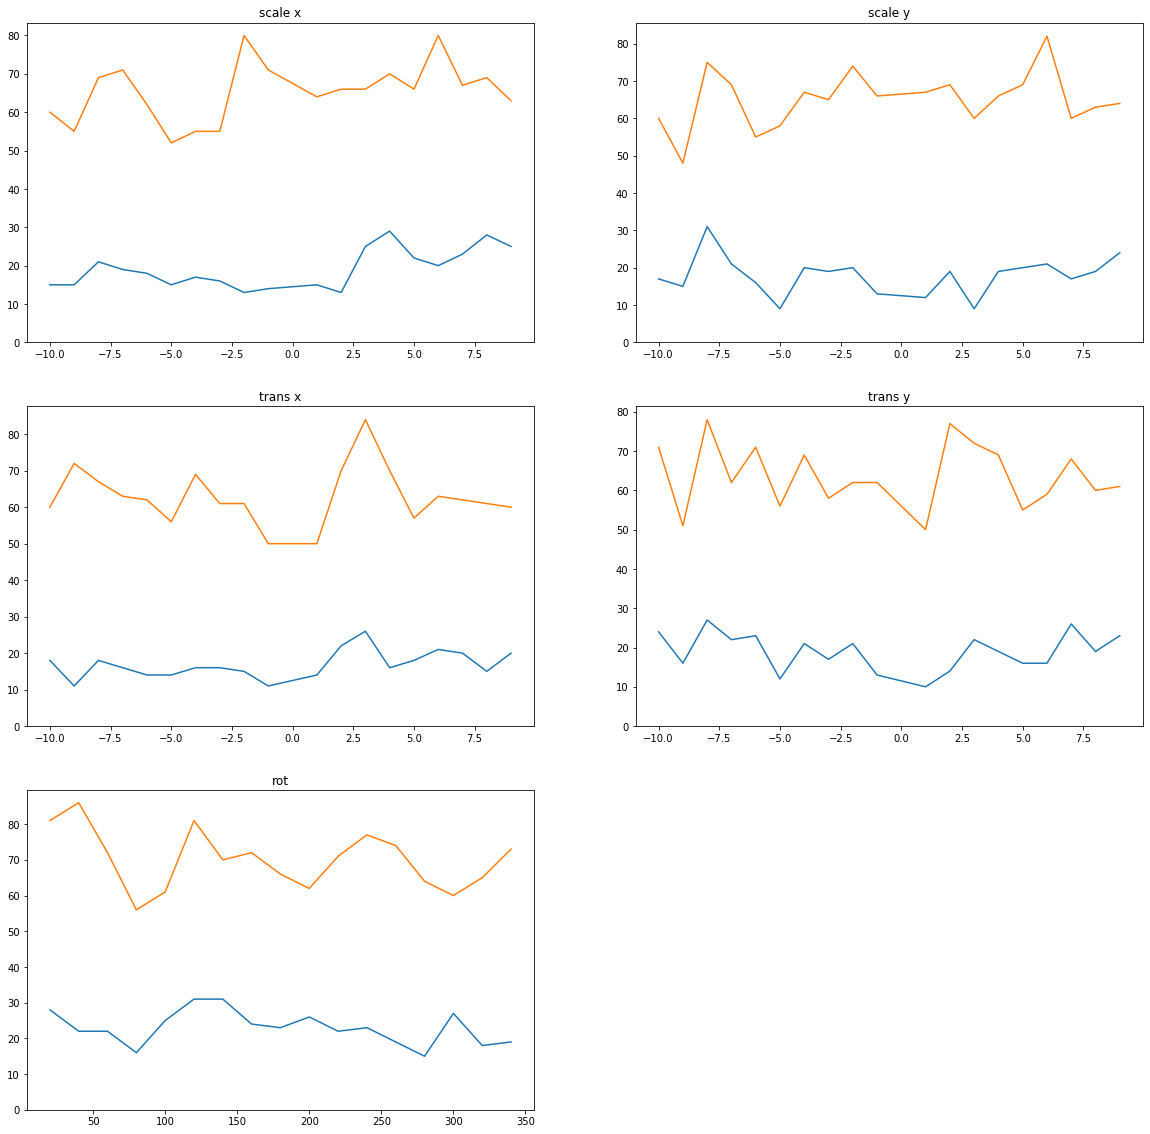

In [15]:
# CELL 15
exps_base = dict()
with open("ch9_cell14_improvements.tsv") as f:
    next(f)
    for line in f:
        cond, param2, value = line.strip().split("\t")
        param1 = None
        if cond[0] in { "x", "y" }:
            param1 = cond[0]
            cond = cond[1:]
        exps_base[cond] = exps_base.get(cond, dict())
        exps_cond = exps_base[cond]
        if param1 is not None:
            exps_cond[param1] = exps_cond.get(param1, dict())
            exps_cond = exps_cond[param1]
        param2 = int(param2)
        exps_cond[param2] = exps_cond.get(param2, dict())
        exps_cond[param2] = int(value)

exps = dict()
has_param1 = set()
with open("ch9_cell14_improvements_perc.tsv") as f:
    next(f)
    for line in f:
        cond, param2, value = line.strip().split("\t")
        param1 = None
        if cond[0] in { "x", "y" }:
            param1 = cond[0]
            cond = cond[1:]
            has_param1.add(cond)
        exps[cond] = exps.get(cond, dict())
        exps_cond = exps[cond]
        if param1 is not None:
            exps_cond[param1] = exps_cond.get(param1, dict())
            exps_cond = exps_cond[param1]
        param2 = int(param2)
        exps_cond[param2] = exps_cond.get(param2, dict())
        exps_cond[param2] = int(value)

from matplotlib import pyplot as plt
%matplotlib inline

total_graphs = len(has_param1) * 2 + (len(exps) - len(has_param1))

plt.rcParams['figure.figsize'] = [20, 20]

for idx, cond in enumerate(exps):
    if cond not in has_param1:
        ax = plt.subplot(len(exps), 2, 2*idx + 1)
        axis = sorted(exps[cond].keys())
        values = list(map(lambda x:exps[cond][x], axis))
        values_base = list(map(lambda x:exps_base[cond][x], axis))
        plt.title(cond)
        plt.plot(axis, values)
        plt.plot(axis, values_base)
        ax.set_ylim(bottom=0)
    else:
        for idx2, param1 in enumerate(exps[cond].keys()):
            ax = plt.subplot(len(exps), 2, 2*idx + idx2 + 1)
            axis = sorted(exps[cond][param1].keys())
            values = list(map(lambda x:exps[cond][param1][x], axis))
            values_base = list(map(lambda x:exps_base[cond][param1][x], axis))
            plt.title(cond + " " + param1)
            plt.plot(axis, values)
            plt.plot(axis, values_base)
            ax.set_ylim(bottom=0)
plt.savefig("ch9_cell15_transformations.pdf", bbox_inches='tight', dpi=300)

That looks pretty good, let's use that for a second featurization expanding the corpus

## Second Featurization

Let us see if we can make them more informative with rotations, translations and scaling (Cell #16).

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html

Read 0 out of 44,959
Read 8,991 out of 44,959
Read 17,982 out of 44,959
Read 26,973 out of 44,959
Read 35,964 out of 44,959
Read 44,955 out of 44,959
Wrote 0 out of 44,959
Wrote 8,991 out of 44,959
Wrote 17,982 out of 44,959
Wrote 26,973 out of 44,959
Wrote 35,964 out of 44,959
Wrote 44,955 out of 44,959
Training on 143,884 cities
using 1,122 features
Baseline training took 94.35736131668091 seconds
Baseline RMSE 0.33000816267927113
Training took 5,815.352689266205 seconds
RMSE 0.3224585323198279


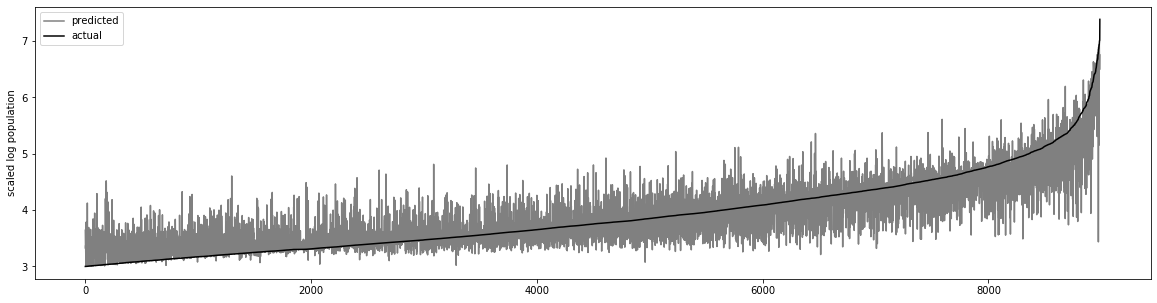

In [16]:
# CELL 16
import math
import random
import cv2
import numpy as np
import time
from sklearn.ensemble import RandomForestRegressor
PARAM_DATA_PATH='./boxes'

header = None
data = list()
with open("ch6_cell32_dev_feat_conservative.tsv") as f:
    header = next(f)
    header = header.strip().split('\t')
    for line in f:
        fields = line.strip().split("\t")
        name = fields.pop(0)
        logpop = float(fields[-1])
        feats = list(map(float, fields[:-1]))
        row = (feats, logpop, name)
        data.append(row)

uri_to_geoid = dict()
with open("ch6_cell1_cities1000_links.ttl") as f:
    for line in f:
        fields = line.split(' ')
        _id = fields[2]
        _id = _id.split('/')[-2]
        uri_to_geoid[fields[0]] = _id

side = 32
header = list(header[:-1]) + [ fname for rowlist in map(lambda x: map(lambda y:"p-{}-{}".format(x,y), 
                                                                      range(side)), range(side))
                              for fname in rowlist ] + [ header[-1] ]
expanded_data = list(data)
rand = random.Random(42)
for idx, row in enumerate(data):
    if idx % (len(data) // 5) == 0:
        print("Read {:,} out of {:,}".format(idx, len(data)))
    feats, _, name = row
    expanded = cv2.imread("{}/{}.png".format(PARAM_DATA_PATH, uri_to_geoid[name]))
    r, _, _ = cv2.split(expanded)
    eside = expanded.shape[0]
    ecentre = eside // 2
    centre = side // 2
    
    ext_feats = feats.copy()
    ext_feats.extend(r[(ecentre - centre):(ecentre+centre),(ecentre - centre):(ecentre+centre)].reshape(-1))
    expanded_data[idx] = [ (np.array(ext_feats), row[1], row[2]) ]
    
    for _ in range(3):
        ext_feats = feats.copy()
        cond = rand.randint(1, 3)
        if cond == 1: # scale
            dsize = rand.randint(1, 7)
            if rand.random() < 0.5:
                dsize = -dsize
            xnew_ecentre = ecentre
            ynew_ecentre = ecentre
            xnew_eside = eside
            ynew_eside = eside
            if rand.random() < 0.5:
                xnew_ecentre = (eside + dsize) // 2
                xnew_eside = eside + dsize
            else:
                ynew_ecentre = (eside + dsize) // 2
                ynew_eside = eside + dsize
            img = cv2.resize(expanded, (xnew_eside, ynew_eside), interpolation=cv2.INTER_CUBIC)
            img, _, _ = cv2.split(img)
            ext_feats.extend( img[(xnew_ecentre - centre):(xnew_ecentre + centre),
                                 (ynew_ecentre - centre):(ynew_ecentre+centre)].reshape(-1) )
        elif cond == 2: # translate
            delta = rand.randint(1, 9)
            if rand.random() < 0.5:
                delta = -delta
            xdelta = 0
            ydelta = 0
            if rand.random() < 0.5:
                xdelta = delta
            else:
                ydelta = delta
            matrix = np.float32([[1,0,xdelta], [0,1,ydelta]])
            img = cv2.warpAffine(expanded, matrix, (eside, eside) )
            img, _, _ = cv2.split(img)
            ext_feats.extend( img[(ecentre - centre):(ecentre + centre),
                                 (ecentre - centre):(ecentre+centre)].reshape(-1) )
        elif cond == 3: # rotate
            angle = rand.randint(1, 17)
            matrix = cv2.getRotationMatrix2D((ecentre, ecentre),angle*20, 1)
            img = cv2.warpAffine(expanded, matrix, (eside, eside) ) 
            img, _, _ = cv2.split(img)
            ext_feats.extend( img[(ecentre - centre):(ecentre + centre),
                                 (ecentre - centre):(ecentre+centre)].reshape(-1) )
        expanded_data[idx].append( (np.array(ext_feats), row[1], row[2]) )
    
# write full file
with open("ch9_cell16_dev_feat2.tsv",  "w") as f:
    f.write("\t".join(header) + '\n')
    for idx, _vars in enumerate(expanded_data):
        if idx % (len(data) // 5) == 0:
            print("Wrote {:,} out of {:,}".format(idx, len(data)))
        for feats, logpop, name in _vars:
            f.write("{}\t{}\t{}\n".format(name, "\t".join(map(lambda x: str(int(x)) if int(x) == x else str(x),
                                                              feats)), logpop))
        
train_data = list()
test_data = list()
rand = random.Random(42)
for _vars in expanded_data:
    if rand.random() < 0.2:
        test_data.append(_vars[0]) 
    else:
        train_data.extend(_vars)
data=None
expanded_data=None
               
train_names = list(map(lambda t:t[2], train_data))

test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest = np.array(list(map(lambda t:t[0], test_data)))
ytest = np.array(list(map(lambda t:t[1], test_data)))
train_data=None
test_data=None

# train RF
print("Training on {:,} cities\nusing {:,} features".format(*xtrain.shape))

start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain[:,:98], ytrain)
print("Baseline training took {:,} seconds".format(time.time() - start))
ytest_pred = rfr.predict(xtest[:,:98])
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("Baseline RMSE", RMSE)

start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain, ytrain)
print("Training took {:,} seconds".format(time.time() - start))
ytest_pred = rfr.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

import pickle
with open("ch9_cell16_model.pk", "wb") as pkl:
    pickle.dump(rfr, pkl)
with open("ch9_cell16_test_names.tsv", "w") as names:
    for idx, name in enumerate(test_names):
        names.write("{}\t{}\n".format(idx, name))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch9_cell16_rf_feat2.pdf", bbox_inches='tight', dpi=300)
plt.legend()

Maximum importance for non-pixel features 0.22869397201503897
Mean importance    for non-pixel features 0.008471273387336331
Maximum importance for pixel     features 0.00046932992809767824
Mean importance    for pixel     features 0.00016583516410257764


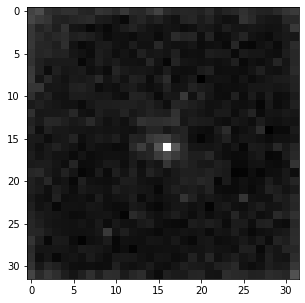

In [17]:
# CELL 17
import pickle
import math

img = cell7_model_to_image("ch9_cell16_model.pk", "ch9_cell16_dev_feat2.tsv")

from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(img, aspect='equal')
plt.savefig("ch9_cell17_rf_feat_importance.pdf", bbox_inches='tight', dpi=300)

That looks quite good. I do not think there is much more value on RF and pixels-as-features. Let us move to histograms, where we can use SVRs.

## Third Featurization

This featurization is rather straightforward. From the EDA it does not look like single pixel values as important, I'll bin every 4 pixels for a total of 64 features (cell #18).


Read 0 out of 44,959
Read 8,991 out of 44,959
Read 17,982 out of 44,959
Read 26,973 out of 44,959
Read 35,964 out of 44,959
Read 44,955 out of 44,959
Wrote 0 out of 44,959
Wrote 8,991 out of 44,959
Wrote 17,982 out of 44,959
Wrote 26,973 out of 44,959
Wrote 35,964 out of 44,959
Wrote 44,955 out of 44,959
Training on 35,971 cities
using 354 features
Baseline training took 19.840296983718872 seconds
Baseline RMSE 0.31895350002111916
Training took 157.52114248275757 seconds
RMSE 0.32652971504024825
Writing files for error analysis


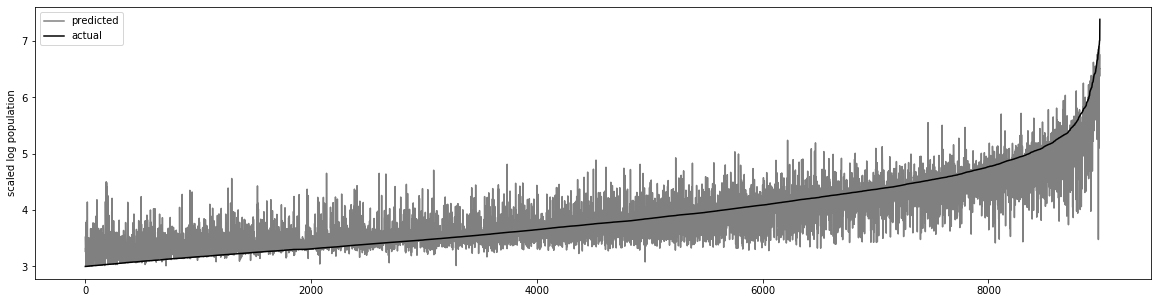

In [18]:
# CELL 18
import math
import random
import cv2
import numpy as np
import time
from sklearn.ensemble import RandomForestRegressor
PARAM_DATA_PATH='./boxes'
PARAM_BINS = 256

header = None
data = list()
with open("ch6_cell32_dev_feat_conservative.tsv") as f:
    header = next(f)
    header = header.strip().split('\t')
    for line in f:
        fields = line.strip().split("\t")
        name = fields.pop(0)
        logpop = float(fields[-1])
        feats = list(map(float, fields[:-1]))
        row = (feats, logpop, name)
        data.append(row)

uri_to_geoid = dict()
with open("ch6_cell1_cities1000_links.ttl") as f:
    for line in f:
        fields = line.split(' ')
        _id = fields[2]
        _id = _id.split('/')[-2]
        uri_to_geoid[fields[0]] = _id

header = list(header[:-1]) + list(map(lambda x: "bin-"+str(x), range(PARAM_BINS))) + [ header[-1] ]
for idx, row in enumerate(data):
    if idx % (len(data) // 5) == 0:
        print("Read {:,} out of {:,}".format(idx, len(data)))
    feats, _, name = row
    img = cv2.imread("{}/{}.png".format(PARAM_DATA_PATH, uri_to_geoid[name]))
    img = cv2.GaussianBlur(img, (3,3), 0)
    hist = cv2.calcHist([img], [0], None, [PARAM_BINS],[0,256])
    feats.extend(hist.reshape(-1))
    data[idx] = (np.array(feats), row[1], row[2])    

# write full file
with open("ch9_cell18_dev_feat3.tsv",  "w") as f:
    f.write("\t".join(header) + '\n')
    for idx, row in enumerate(data):
        if idx % (len(data) // 5) == 0:
            print("Wrote {:,} out of {:,}".format(idx, len(data)))
        feats, logpop, name = row
        f.write("{}\t{}\t{}\n".format(name, "\t".join(map(lambda x: str(int(x)) if int(x) == x else str(x),
                                                          feats)), logpop))
        
train_data = list()
test_data = list()
rand = random.Random(42)
for row in data:
    if rand.random() < 0.2:
        test_data.append(row) 
    else:
        train_data.append(row)
data=None
               
train_names = list(map(lambda t:t[2], train_data))

test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))
train_names = list(map(lambda t:t[2], train_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest = np.array(list(map(lambda t:t[0], test_data)))
ytest = np.array(list(map(lambda t:t[1], test_data)))
train_data=None
test_data=None

# train RF
print("Training on {:,} cities\nusing {:,} features".format(*xtrain.shape))

start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain[:,:98], ytrain)
print("Baseline training took {:,} seconds".format(time.time() - start))
ytest_pred = rfr.predict(xtest[:,:98])
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("Baseline RMSE", RMSE)

start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain, ytrain)
print("Training took {:,} seconds".format(time.time() - start))
ytest_pred = rfr.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

print("Writing files for error analysis")
np.savez_compressed("ch9_cell18_feat3_rf.npz", 
                    xtrain=xtrain, ytrain=ytrain,
                    xtest=xtest, ytest=ytest,
                    ytest_pred=ytest_pred)
import pickle
with open("ch9_cell18_model.pk", "wb") as pkl:
    pickle.dump(rfr, pkl)
with open("ch9_cell18_train_names.tsv", "w") as names:
    for idx, name in enumerate(train_names):
        names.write("{}\t{}\n".format(idx, name))
with open("ch9_cell18_test_names.tsv", "w") as names:
    for idx, name in enumerate(test_names):
        names.write("{}\t{}\n".format(idx, name))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch9_cell18_svr_feat3.pdf", bbox_inches='tight', dpi=300)
plt.legend()

That did not work as well as I would have expected, let us try less bins (Cell #19)

Read 0 out of 44,959
Read 8,991 out of 44,959
Read 17,982 out of 44,959
Read 26,973 out of 44,959
Read 35,964 out of 44,959
Read 44,955 out of 44,959
Wrote 0 out of 44,959
Wrote 8,991 out of 44,959
Wrote 17,982 out of 44,959
Wrote 26,973 out of 44,959
Wrote 35,964 out of 44,959
Wrote 44,955 out of 44,959
Training on 35,971 cities
using 130 features
Baseline training took 19.73343014717102 seconds
Baseline RMSE 0.31895350002111916
Training took 43.17177772521973 seconds
RMSE 0.3208842412682489
Writing files for error analysis


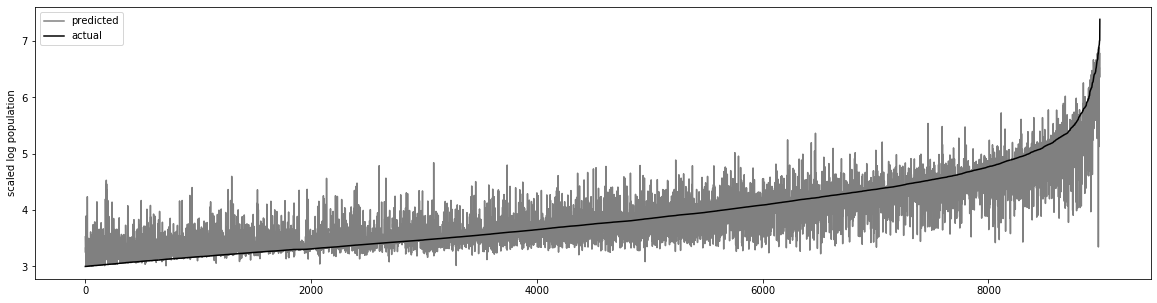

In [19]:
# CELL 19
import math
import random
import cv2
import numpy as np
import time
from sklearn.svm import SVR
PARAM_DATA_PATH='./boxes'
PARAM_BINS = 32

header = None
data = list()
with open("ch6_cell32_dev_feat_conservative.tsv") as f:
    header = next(f)
    header = header.strip().split('\t')
    for line in f:
        fields = line.strip().split("\t")
        name = fields.pop(0)
        logpop = float(fields[-1])
        feats = list(map(float, fields[:-1]))
        row = (feats, logpop, name)
        data.append(row)

uri_to_geoid = dict()
with open("ch6_cell1_cities1000_links.ttl") as f:
    for line in f:
        fields = line.split(' ')
        _id = fields[2]
        _id = _id.split('/')[-2]
        uri_to_geoid[fields[0]] = _id

header = list(header[:-1]) + list(map(lambda x: "bin-"+str(x), range(PARAM_BINS))) + [ header[-1] ]
for idx, row in enumerate(data):
    if idx % (len(data) // 5) == 0:
        print("Read {:,} out of {:,}".format(idx, len(data)))
    feats, _, name = row
    img = cv2.imread("{}/{}.png".format(PARAM_DATA_PATH, uri_to_geoid[name]))
    img = cv2.GaussianBlur(img, (3,3), 0)
    hist = cv2.calcHist([img], [0], None, [PARAM_BINS],[0,256])
    feats.extend(hist.reshape(-1))
    data[idx] = (np.array(feats), row[1], row[2])    

# write full file
with open("ch9_cell19_dev_feat3_bin32.tsv",  "w") as f:
    f.write("\t".join(header) + '\n')
    for idx, row in enumerate(data):
        if idx % (len(data) // 5) == 0:
            print("Wrote {:,} out of {:,}".format(idx, len(data)))
        feats, logpop, name = row
        f.write("{}\t{}\t{}\n".format(name, "\t".join(map(lambda x: str(int(x)) if int(x) == x else str(x),
                                                          feats)), logpop))
        
train_data = list()
test_data = list()
rand = random.Random(42)
for row in data:
    if rand.random() < 0.2:
        test_data.append(row) 
    else:
        train_data.append(row)
data=None
               
train_names = list(map(lambda t:t[2], train_data))

test_data   = sorted(test_data, key=lambda t:t[1])
test_names  = list(map(lambda t:t[2], test_data))
train_names = list(map(lambda t:t[2], train_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))
train_data = None
test_data  = None

# train RF
print("Training on {:,} cities\nusing {:,} features".format(*xtrain.shape))


start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain[:,:98], ytrain)
print("Baseline training took {:,} seconds".format(time.time() - start))
ytest_pred = rfr.predict(xtest[:,:98])
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("Baseline RMSE", RMSE)

start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain, ytrain)
print("Training took {:,} seconds".format(time.time() - start))
ytest_pred = rfr.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

print("Writing files for error analysis")
np.savez_compressed("ch9_cell19_feat3_rf_bin32.npz", 
                    xtrain=xtrain, ytrain=ytrain,
                    xtest =xtest,   ytest=ytest,
                    ytest_pred  = ytest_pred)
import pickle
with open("ch9_cell19_model.pk", "wb") as pkl:
    pickle.dump(rfr, pkl)
with open("ch9_cell19_train_names.tsv", "w") as names:
    for idx, name in enumerate(train_names):
        names.write("{}\t{}\n".format(idx, name))
with open("ch9_cell19_test_names.tsv", "w") as names:
    for idx, name in enumerate(test_names):
        names.write("{}\t{}\n".format(idx, name))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest,      label="actual",    color='black')
plt.ylabel('scaled log population')
plt.savefig("ch9_cell19_svr_feat3_bin32.pdf", bbox_inches='tight', dpi=300)
plt.legend()

Still worse than baseline. Let us see if this model is more robust under transformations (Cell #20).

Working with 32 bins
Row 0 out of 7,195 (0), total experiments so far 0
Row 1,439 out of 7,195 (307), total experiments so far 2,803
Row 2,878 out of 7,195 (578), total experiments so far 5,323
Row 4,317 out of 7,195 (862), total experiments so far 8,032
Row 5,756 out of 7,195 (1,167), total experiments so far 10,938
Row 7,195 out of 7,195 (1,454), total experiments so far 13,649
Row 8,634 out of 7,195 (1,752), total experiments so far 16,418
Total experiments 17121
Total improvements 7780
Total improvement 50% 3464
Total for rot: 1,454 improvements
Total for rot: 659 50% improvements
Total for xscale: 1,625 improvements
Total for xscale: 707 50% improvements
Total for xtrans: 1,561 improvements
Total for xtrans: 694 50% improvements
Total for yscale: 1,589 improvements
Total for yscale: 691 50% improvements
Total for ytrans: 1,551 improvements
Total for ytrans: 713 50% improvements


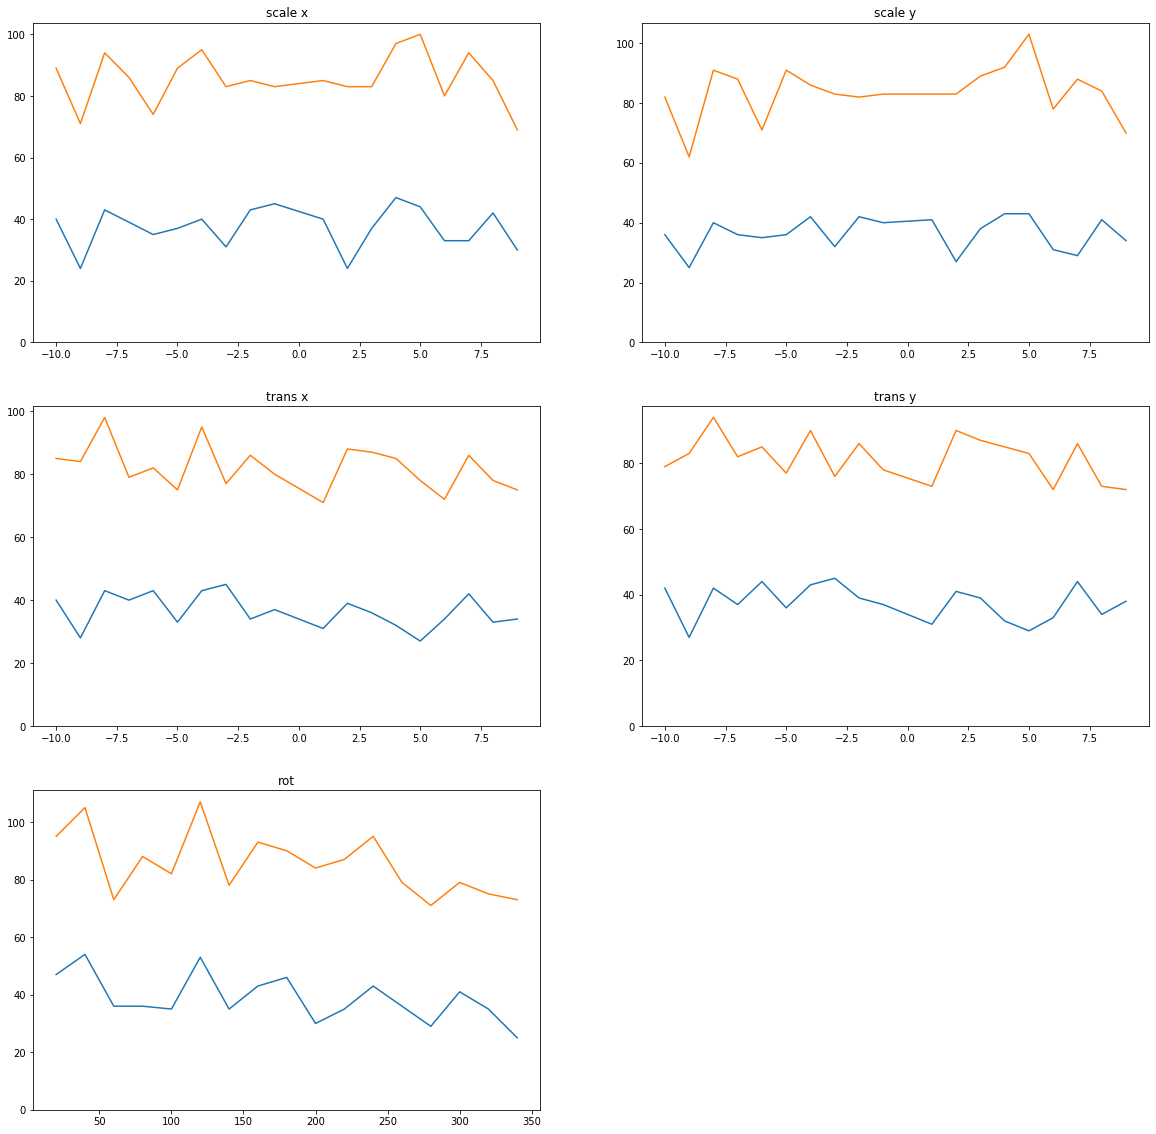

In [20]:
# CELL 20
import math
import random
import time
import pickle
from collections import OrderedDict

import cv2
import numpy as np

PARAM_DATA_PATH='./boxes'

loaded = np.load("ch9_cell19_feat3_rf_bin32.npz")
xtest          = loaded['xtest']
ytest          = loaded['ytest']
ytest_pred     = loaded['ytest_pred']
                  
# get feature names
header = None
with open("ch9_cell19_dev_feat3_bin32.tsv") as f:
    header = next(f)
    header = header.strip().split('\t')
    header.pop() # population
    header.pop(0) # name

base_size = list(filter(lambda x:x[1].startswith("bin-"), enumerate(header)))[0][0]
bins      = len(list(filter(lambda x:x.startswith("bin-"), header)))
print("Working with", bins, "bins")
side = 32

# get test names
test_names = list()
with open("ch9_cell19_test_names.tsv") as f:
    for line in f:
        test_names.append(line.strip().split('\t')[-1])
        
# geoids
uri_to_geoid = dict()
with open("ch6_cell1_cities1000_links.ttl") as f:
    for line in f:
        fields = line.split(' ')
        _id = fields[2]
        _id = _id.split('/')[-2]
        uri_to_geoid[fields[0]] = _id
        
# model
with open("ch9_cell19_model.pk", "rb") as pkl:
    rfr = pickle.load(pkl)

improved      = OrderedDict()
improved_perc = OrderedDict()
exp  = 0
imgs = 0
rand = random.Random(42)
for idx in range(ytest.shape[0]):
    if idx % (ytrain_pred.shape[0] // 5) == 0:
        print("Row {:,} out of {:,} ({:,}), total experiments so far {:,}"
              .format(idx, ytrain_pred.shape[0], imgs, exp))
    if rand.random() > 0.2:
        continue
    imgs += 1
    target   = ytest[idx]
    baseline = (target - ytest_pred[idx])**2
    baseline_perc = baseline * 0.5
    
    # get original 64x64 box
    name = test_names[idx]
    expanded = cv2.imread("{}/{}.png".format(PARAM_DATA_PATH, uri_to_geoid[name]))
    eside    = expanded.shape[0]
    ecentre  = eside // 2
    centre   = side // 2

    orig = xtest[idx,:]
    row  = orig.copy().reshape( (1, -1) )
    
    def eval_img(img):
        hist = cv2.calcHist([img], [0], None, [bins],[0,256])
        row[0][base_size:] = hist.reshape(-1)
        pred = rfr.predict(row)[0]
        return pred
    
    # scale
    for dsize in range(-10,10):
        if dsize == 0 or rand.random() > 0.1:
            continue
        new_ecentre = (eside + dsize) // 2
        # x
        cond = 'xscale={}'.format(dsize)
        img = cv2.resize(expanded, (eside + dsize, eside), interpolation=cv2.INTER_CUBIC)
        img, _, _ = cv2.split(img)
        pred = eval_img(img[(new_ecentre - centre):(new_ecentre + centre),
                                 (ecentre - centre):(ecentre+centre)].reshape(-1))
        exp += 1
        if (target - pred)**2 < baseline:
            improved[cond] = improved.get(cond, 0) + 1
            if (target - pred)**2 < baseline_perc:
                improved_perc[cond] = improved_perc.get(cond, 0) + 1
        # y
        cond = 'yscale={}'.format(dsize)
        img = cv2.resize(expanded, (eside, eside  + dsize), interpolation=cv2.INTER_CUBIC)
        img, _, _ = cv2.split(img)
        pred = eval_img(img[(ecentre - centre):(ecentre + centre),
                                 (new_ecentre - centre):(new_ecentre+centre)].reshape(-1))
        exp += 1
        if (target - pred)**2 < baseline:
            improved[cond] = improved.get(cond, 0) + 1
            if (target - pred)**2 < baseline_perc:
                improved_perc[cond] = improved_perc.get(cond, 0) + 1
            
    # translate
    for delta in range(-10,10):
        if delta == 0  or rand.random() > 0.1:
            continue
        # x
        cond = 'xtrans={}'.format(delta)
        matrix = np.float32([[1,0,delta], [0,1,0]])
        img = cv2.warpAffine(expanded, matrix, (eside, eside) )
        img, _, _ = cv2.split(img)
        pred = eval_img(img[(ecentre - centre):(ecentre + centre),
                                 (ecentre - centre):(ecentre+centre)].reshape(-1))
        exp += 1
        if (target - pred)**2 < baseline:
            improved[cond] = improved.get(cond, 0) + 1
            if (target - pred)**2 < baseline_perc:
                improved_perc[cond] = improved_perc.get(cond, 0) + 1
        # y
        cond = 'ytrans={}'.format(delta)
        matrix = np.float32([[1,0,0], [0,1,delta]])
        img = cv2.warpAffine(expanded, matrix, (eside, eside) )
        img, _, _ = cv2.split(img)
        pred = eval_img(img[(ecentre - centre):(ecentre + centre),
                                 (ecentre - centre):(ecentre + centre)].reshape(-1))
        exp += 1
        if (target - pred)**2 < baseline:
            improved[cond] = improved.get(cond, 0) + 1
            if (target - pred)**2 < baseline_perc:
                improved_perc[cond] = improved_perc.get(cond, 0) + 1
    
    # rotate
    for angle in range(1, 18):
        if rand.random() > 0.1:
            continue
        cond = 'rot={}'.format(angle * 20)
        matrix = cv2.getRotationMatrix2D((ecentre, ecentre),angle*20, 1)
        img = cv2.warpAffine(expanded, matrix, (eside, eside) ) 
        img, _, _ = cv2.split(img)
        pred = eval_img(img[(ecentre - centre):(ecentre + centre),
                                 (ecentre - centre):(ecentre + centre)].reshape(-1))
        exp += 1
        if (target - pred)**2 < baseline:
            improved[cond] = improved.get(cond, 0) + 1
            if (target - pred)**2 < baseline_perc:
                improved_perc[cond] = improved_perc.get(cond, 0) + 1

with open("ch9_cell20_improvements.tsv", "w") as f:
    f.write("condition\tparam\tcount\n")
    for key, value in improved.items():
        cond, param = key.split("=")
        f.write("{}\t{}\t{}\n".format(cond, param, value))
with open("ch9_cell20_improvements_perc.tsv", "w") as f:
    f.write("condition\tparam\tcount\n")
    for key, value in improved_perc.items():
        cond, param = key.split("=")
        f.write("{}\t{}\t{}\n".format(cond, param, value))

print("Total experiments", exp)
print("Total improvements", sum(improved.values()))
print("Total improvement 50%", sum(improved_perc.values()))
conditions = set(map(lambda x:x.split("=")[0],improved.keys()))
for condition in sorted(conditions):
    accum      = 0
    accum_perc = 0
    for key, value in improved.items():
        if key.split("=")[0] == condition:
            accum += value
    for key, value in improved_perc.items():
        if key.split("=")[0] == condition:
            accum_perc += value
    print("Total for {}: {:,} improvements".format(condition, accum))
    print("Total for {}: {:,} 50% improvements".format(condition, accum_perc))
    
exps_base  = dict()
has_param1 = set()
with open("ch9_cell20_improvements.tsv") as f:
    next(f)
    for line in f:
        cond, param2, value = line.strip().split("\t")
        param1 = None
        if cond[0] in { "x", "y" }:
            param1 = cond[0]
            cond = cond[1:]
        exps_base[cond] = exps_base.get(cond, dict())
        exps_cond = exps_base[cond]
        if param1 is not None:
            has_param1.add(cond)
            exps_cond[param1] = exps_cond.get(param1, dict())
            exps_cond = exps_cond[param1]
        param2 = int(param2)
        exps_cond[param2] = exps_cond.get(param2, dict())
        exps_cond[param2] = int(value)

exps = dict()
with open("ch9_cell20_improvements_perc.tsv") as f:
    next(f)
    for line in f:
        cond, param2, value = line.strip().split("\t")
        param1 = None
        if cond[0] in { "x", "y" }:
            param1 = cond[0]
            cond = cond[1:]
        exps[cond] = exps.get(cond, dict())
        exps_cond = exps[cond]
        if param1 is not None:
            exps_cond[param1] = exps_cond.get(param1, dict())
            exps_cond = exps_cond[param1]
        param2 = int(param2)
        exps_cond[param2] = exps_cond.get(param2, dict())
        exps_cond[param2] = int(value)

from matplotlib import pyplot as plt
%matplotlib inline

total_graphs = len(has_param1) * 2 + (len(exps) - len(has_param1))

plt.rcParams['figure.figsize'] = [20, 20]

for idx, cond in enumerate(exps_base):
    if cond not in has_param1:
        ax = plt.subplot(len(exps_base), 2, 2*idx + 1)
        axis = sorted(exps_base[cond].keys())
        if cond in exps:
            values = list(map(lambda x:exps[cond][x], axis))
        else:
            values = [0.0] * len(axis)
        values_base = list(map(lambda x:exps_base[cond][x], axis))
        plt.title(cond)
        plt.plot(axis, values)
        plt.plot(axis, values_base)
        ax.set_ylim(bottom=0)
    else:
        for idx2, param1 in enumerate(exps_base[cond].keys()):
            ax = plt.subplot(len(exps_base), 2, 2*idx + idx2 + 1)
            axis = sorted(exps_base[cond][param1].keys())
            if cond in exps:
                values = list(map(lambda x:exps[cond][param1][x], axis))
            else:
                values = [0.0] * len(axis)
            values_base = list(map(lambda x:exps_base[cond][param1][x], axis))
            plt.title(cond + " " + param1)
            plt.plot(axis, values)
            plt.plot(axis, values_base)
            ax.set_ylim(bottom=0)
plt.savefig("ch9_cell20_transformations.pdf", bbox_inches='tight', dpi=300)

The histograms seem to have lived to their robustness expectation, let's move on to local feature detectors.

## Fourth Featurization

We'll use the Harris Corner detector (Cell #21).

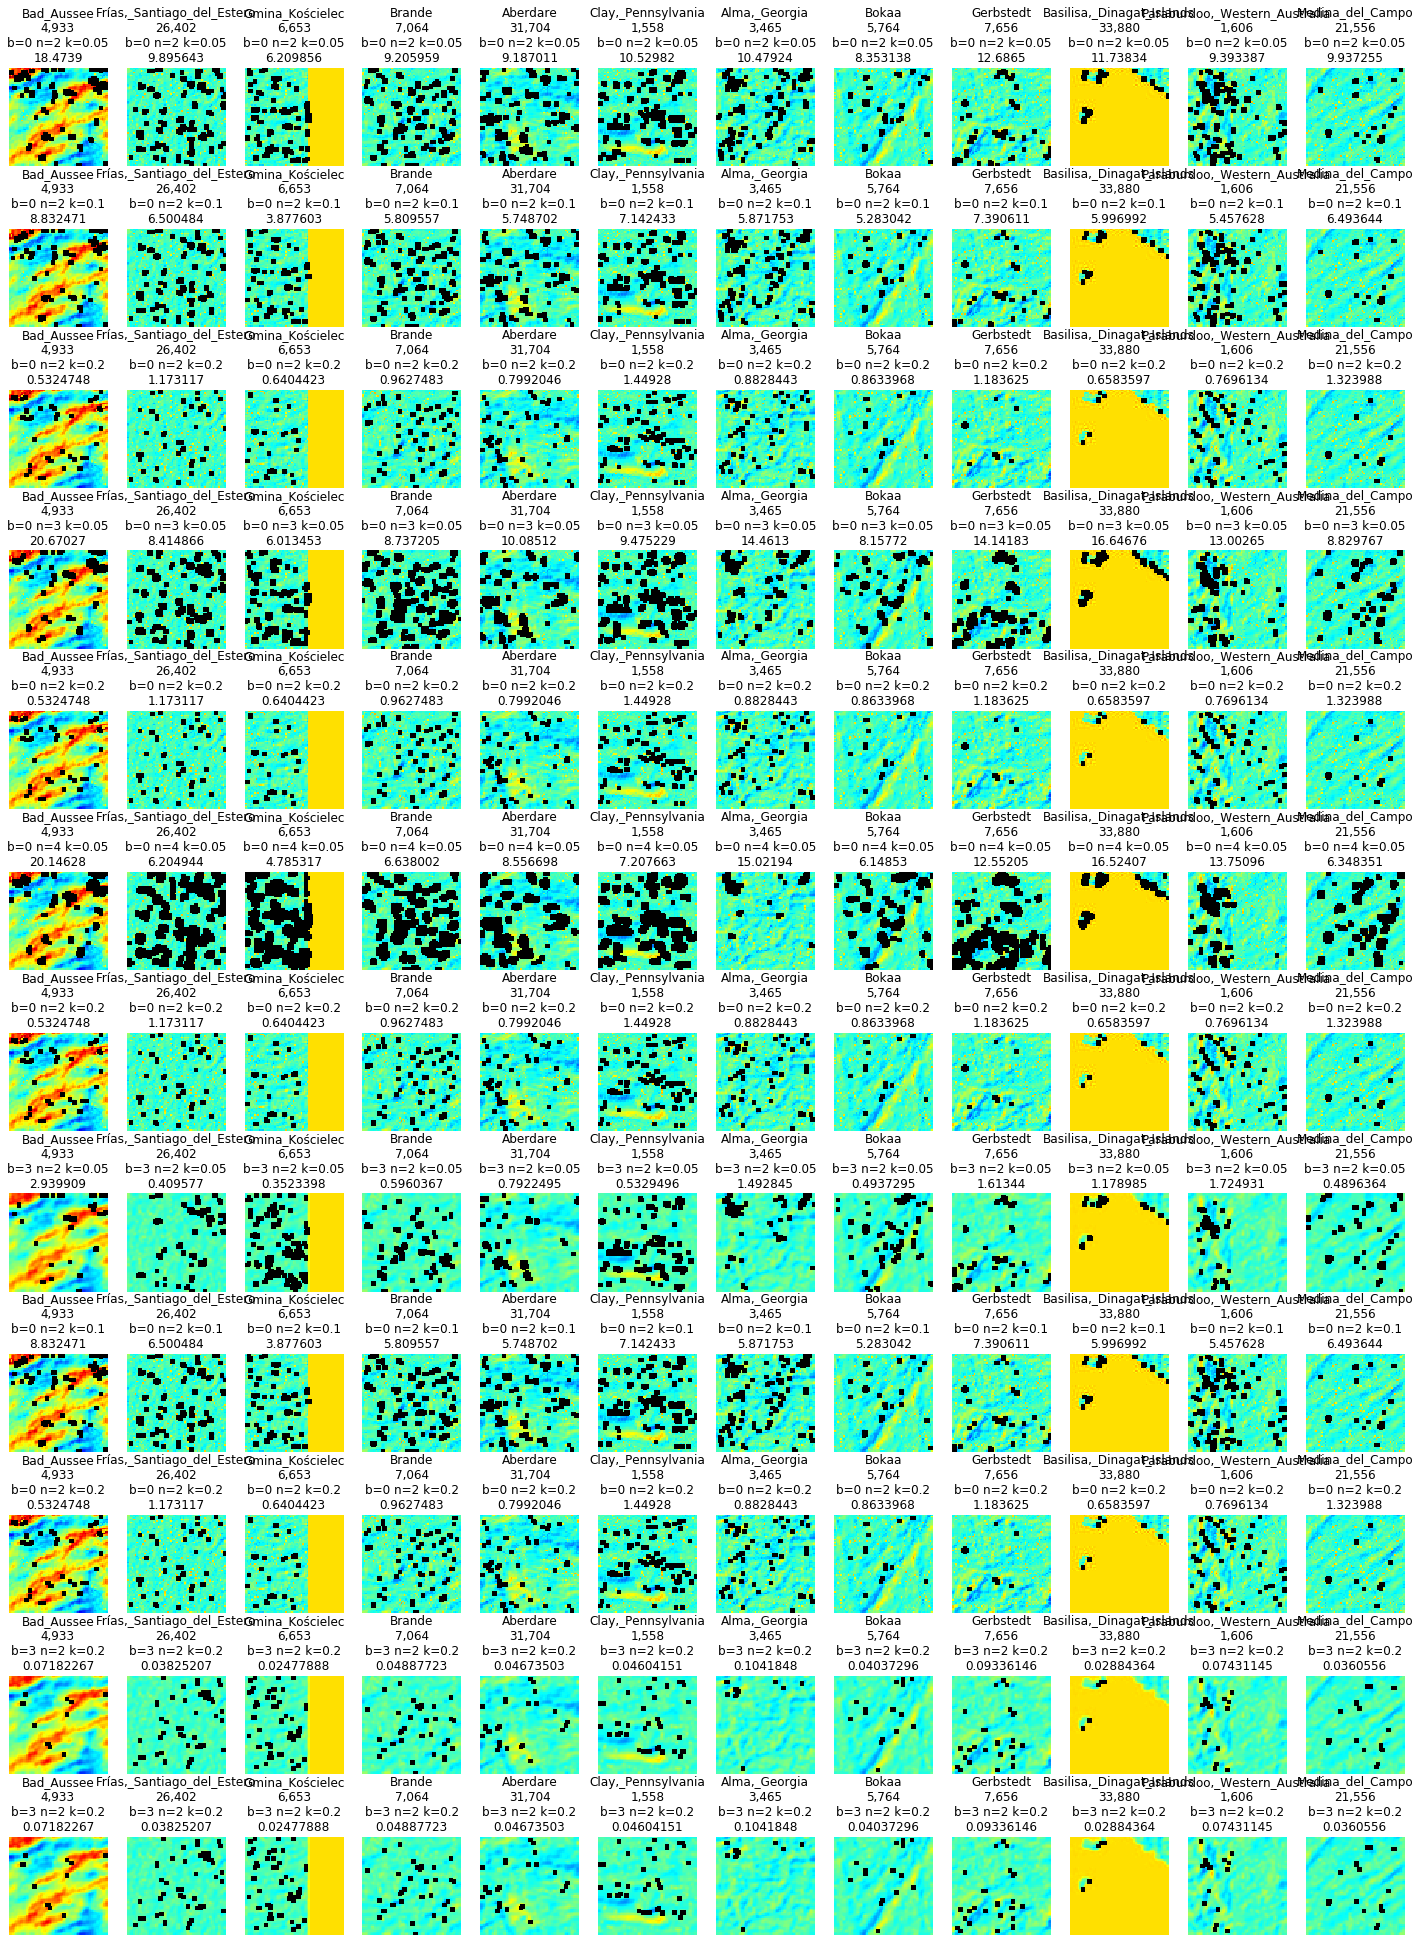

In [21]:
# CELL 21
import random
import cv2
import numpy as np
PARAM_DATA_PATH='./boxes'

dev_uris = set()
pop = dict()
with open("ch6_cell32_dev_feat_conservative.tsv") as f:
    next(f) # header
    for line in f:
        fields = line.strip().split("\t")
        dev_uris.add(fields[0])
        pop[fields[0]] = fields[-1]

cities = list()
with open("ch9_cell1_cities1000_gps.tsv") as f:
    next(f) # header
    for line in f:
        uri, geoid, lat, lon = line.split("\t")
        if uri in dev_uris:
            cities.append( (uri, geoid, float(lat), float(lon)) )

rand = random.Random(42)
rand.shuffle(cities)

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [25, 35]

# condition is blur, neighbor size, harris k
conds = [ (0, 2, 0.05), (0, 2, 0.1),  (0, 2, 0.2),
          (0, 3, 0.05), (0, 2, 0.2),
          (0, 4, 0.05), (0, 2, 0.2),
          (3, 2, 0.05), (0, 2, 0.1),  (0, 2, 0.2),
          (3, 2, 0.2),
          (3, 2, 0.2) ]
for cond_idx, cond in enumerate(conds):
    blur, neig, k = cond
    for idx, row in enumerate(cities[:12]):
        uri, geoid, lat, lon = row
        name = uri.split("/")[-1][:-1]
        plt.subplot(len(conds),12, 12*cond_idx + idx+1)
        img = cv2.imread("{}/{}.png".format(PARAM_DATA_PATH, geoid))
        if blur > 0:
            img = cv2.GaussianBlur(img, (blur, blur), 0)
        r, _, _ = cv2.split(img)
        corners = cv2.cornerHarris(r, neig, 3, k)
        cornerness = np.sort(corners.reshape(-1))[-100:].sum() * 1000

        img2 = cv2.applyColorMap(img, cv2.COLORMAP_JET)
        corners = cv2.dilate(corners, None) # for show
        img2[corners > 0.1*corners.max()]=[0,0,0]
        plt.imshow(img2)
        plt.axis('off')
        plt.title("{}\n{:,}\nb={} n={} k={}\n{:1.7}".format(
            name, int(10**float(pop[uri])), 
            blur, neig, k, cornerness))
plt.savefig("ch9_cell21_corners.pdf", bbox_inches='tight', dpi=300)
plt.show()

While higher values of blurring and larger context produce less corners at 10% from the maximum value, it becomes less discriminative. I choose b=3, n=2, k=0.05 for the experiments.

Harris corner detector is intended to be threshold, with a threshold that is image dependent. To get away from needing to specify a threshold, I rank the values and add the top 100 values (the "cornerness" score above). Let us see how it fares in Cell #22.

Read 0 out of 44,959
Read 8,991 out of 44,959
Read 17,982 out of 44,959
Read 26,973 out of 44,959
Read 35,964 out of 44,959
Read 44,955 out of 44,959
Training on 35,971 cities
using 99 features
Baseline training took 22.092710733413696 seconds
Baseline RMSE 0.3189535000211191
Training took 24.13033366203308 seconds
RMSE 0.32130057937421597
Writing files for error analysis


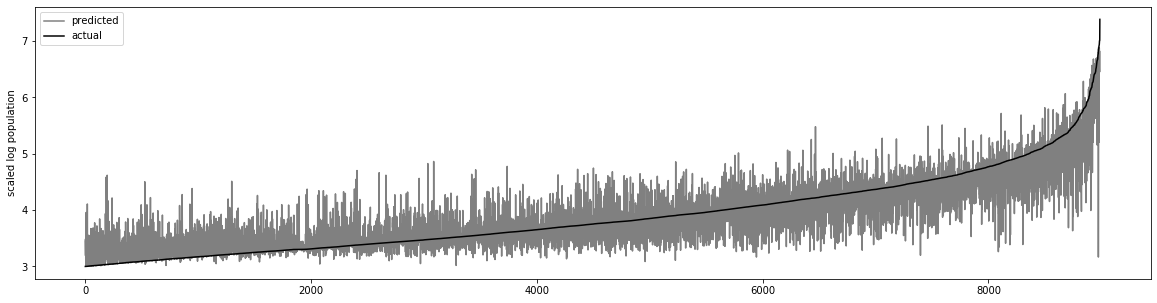

In [22]:
# CELL 22
import math
import random
import cv2
import numpy as np
import time
from sklearn.ensemble import RandomForestRegressor
PARAM_DATA_PATH='./boxes'
PARAM_BLUR = 3
PARAM_NEIG = 2
PARAM_K = 0.05

header = None
data = list()
with open("ch6_cell32_dev_feat_conservative.tsv") as f:
    header = next(f)
    header = header.strip().split('\t')
    for line in f:
        fields = line.strip().split("\t")
        name = fields.pop(0)
        logpop = float(fields[-1])
        feats = list(map(float, fields[:-1]))
        row = (feats, logpop, name)
        data.append(row)

uri_to_geoid = dict()
with open("ch6_cell1_cities1000_links.ttl") as f:
    for line in f:
        fields = line.split(' ')
        _id = fields[2]
        _id = _id.split('/')[-2]
        uri_to_geoid[fields[0]] = _id

header = list(header[:-1]) + [ "cornerness" ] + [ header[-1] ]
for idx, row in enumerate(data):
    if idx % (len(data) // 5) == 0:
        print("Read {:,} out of {:,}".format(idx, len(data)))
    feats, _, name = row
    img = cv2.imread("{}/{}.png".format(PARAM_DATA_PATH, uri_to_geoid[name]))
    if PARAM_BLUR > 0:
        img = cv2.GaussianBlur(img, (PARAM_BLUR, PARAM_BLUR), 0)
    r, _, _ = cv2.split(img)
    #r = r[16:48, 16:48]
    corners = cv2.cornerHarris(r, PARAM_NEIG, 5, PARAM_K)
    cornerness = np.sort(corners.reshape(-1))[-5:].sum()
    feats.append(cornerness)
    data[idx] = (np.array(feats), row[1], row[2])    

# write full file
with open("ch9_cell22_dev_feat4.tsv",  "w") as f:
    f.write("\t".join(header) + '\n')
    for idx, row in enumerate(data):
        feats, logpop, name = row
        f.write("{}\t{}\t{}\n".format(name, "\t".join(map(lambda x: str(int(x)) if int(x) == x else str(x),
                                                          feats)), logpop))

train_data = list()
test_data = list()
rand = random.Random(42)
for row in data:
    if rand.random() < 0.2:
        test_data.append(row) 
    else:
        train_data.append(row)
data = None
               
train_names = list(map(lambda t:t[2], train_data))

test_data  = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))
train_data = None
test_data  = None

# train RF
print("Training on {:,} cities\nusing {:,} features".format(*xtrain.shape))

start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain[:,:98], ytrain)
print("Baseline training took {:,} seconds".format(time.time() - start))
ytest_pred = rfr.predict(xtest[:,:98])
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("Baseline RMSE", RMSE)

start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain, ytrain)
print("Training took {:,} seconds".format(time.time() - start))
ytest_pred = rfr.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

print("Writing files for error analysis")
np.savez_compressed("ch9_cell22_feat4_rf.npz", 
                    xtrain=xtrain, ytrain=ytrain,
                    xtest=xtest, ytest=ytest,
                    ytest_pred=ytest_pred)
import pickle
with open("ch9_cell22_model.pk", "wb") as pkl:
    pickle.dump(rfr, pkl)
with open("ch9_cell22_test_names.tsv", "w") as names:
    for idx, name in enumerate(test_names):
        names.write("{}\t{}\n".format(idx, name))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch9_cell22_rf_feat4.pdf", bbox_inches='tight', dpi=300)
plt.legend()

Finding the right threshold is hard, let's use the cv2 function "goodFeaturesToTrack" (Cell #23).

Read 0 out of 44,959
Read 8,991 out of 44,959
Read 17,982 out of 44,959
Read 26,973 out of 44,959
Read 35,964 out of 44,959
Read 44,955 out of 44,959
Training on 35,971 cities
using 99 features
Baseline training took 21.215734243392944 seconds
Baseline RMSE 0.3189535000211191
Training took 20.423022270202637 seconds
RMSE 0.31882312699051263


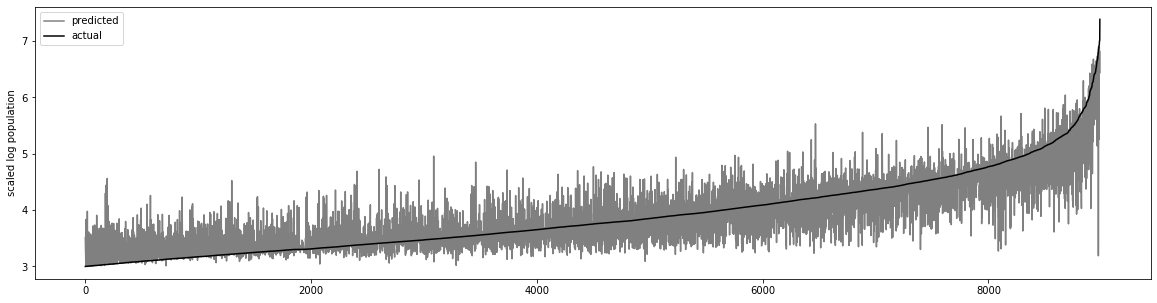

In [23]:
# CELL 23
import math
import random
import cv2
import numpy as np
import time
from sklearn.ensemble import RandomForestRegressor
PARAM_DATA_PATH='./boxes'
PARAM_BLUR = 3

header = None
data = list()
with open("ch6_cell32_dev_feat_conservative.tsv") as f:
    header = next(f)
    header = header.strip().split('\t')
    for line in f:
        fields = line.strip().split("\t")
        name = fields.pop(0)
        logpop = float(fields[-1])
        feats = list(map(float, fields[:-1]))
        row = (feats, logpop, name)
        data.append(row)

uri_to_geoid = dict()
with open("ch6_cell1_cities1000_links.ttl") as f:
    for line in f:
        fields = line.split(' ')
        _id = fields[2]
        _id = _id.split('/')[-2]
        uri_to_geoid[fields[0]] = _id

header = list(header[:-1]) + [ "corners" ] + [ header[-1] ]
for idx, row in enumerate(data):
    if idx % (len(data) // 5) == 0:
        print("Read {:,} out of {:,}".format(idx, len(data)))
    feats, _, name = row
    img = cv2.imread("{}/{}.png".format(PARAM_DATA_PATH, uri_to_geoid[name]))
    if PARAM_BLUR > 0:
        img = cv2.GaussianBlur(img, (PARAM_BLUR, PARAM_BLUR), 0)
    r, _, _ = cv2.split(img)
    corners = cv2.goodFeaturesToTrack(r, 1000, 0.5, 32, None)
    feats.append(0 if corners is None else len(corners))
    data[idx] = (np.array(feats), row[1], row[2])    

# write full file
with open("ch9_cell23_dev_feat4_good_features.tsv",  "w") as f:
    f.write("\t".join(header) + '\n')
    for idx, row in enumerate(data):
        feats, logpop, name = row
        f.write("{}\t{}\t{}\n".format(name, "\t".join(map(lambda x: str(int(x)) if int(x) == x else str(x),
                                                          feats)), logpop))

train_data = list()
test_data = list()
rand = random.Random(42)
for row in data:
    if rand.random() < 0.2:
        test_data.append(row) 
    else:
        train_data.append(row)
data=None
               
train_names = list(map(lambda t:t[2], train_data))

test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest = np.array(list(map(lambda t:t[0], test_data)))
ytest = np.array(list(map(lambda t:t[1], test_data)))
train_data=None
test_data=None

# train RF
print("Training on {:,} cities\nusing {:,} features".format(*xtrain.shape))

start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain[:,:98], ytrain)
print("Baseline training took {:,} seconds".format(time.time() - start))
ytest_pred = rfr.predict(xtest[:,:98])
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("Baseline RMSE", RMSE)

start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain, ytrain)
print("Training took {:,} seconds".format(time.time() - start))
ytest_pred = rfr.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch9_cell23_rf_feat4_good_features.pdf", bbox_inches='tight', dpi=300)
plt.legend()

For error analysis, let us plot number of corners versus population (Cell #24).

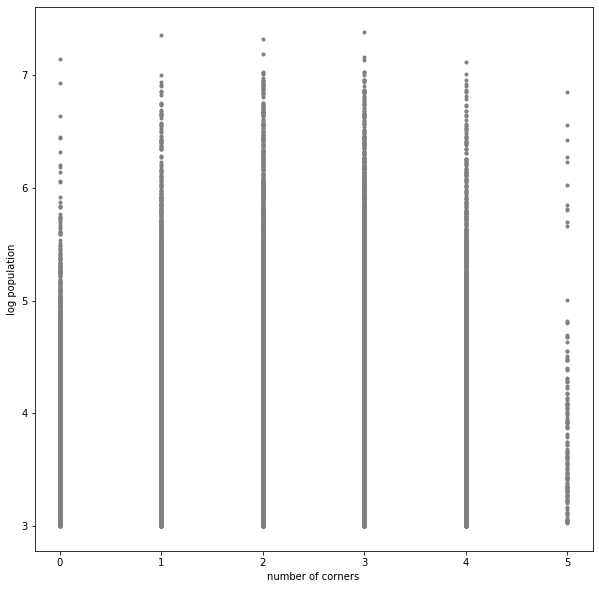

In [24]:
# CELL 24
logpops = list()
total_corners = list()
with open("ch9_cell23_dev_feat4_good_features.tsv") as f:
    next(f) # header
    for line in f:
        fields = line.strip().split("\t")
        fields = fields[-2:]
        corners = int(float(fields[-2]))
        logpop = float(fields[-1])
        total_corners.append(corners)
        logpops.append(logpop)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(total_corners, logpops, '.', color='gray')
plt.ylabel('log population')
plt.xlabel('number of corners')
plt.savefig("ch9_cell24_logpop_vs_corners.pdf", bbox_inches='tight', dpi=300)

## Fifth Featurization

To conclude, let us look at the HOGs. Cell #25.

Read 0 out of 44,959
Read 8,991 out of 44,959
Read 17,982 out of 44,959
Read 26,973 out of 44,959
Read 35,964 out of 44,959
Read 44,955 out of 44,959
Wrote 0 out of 44,959
Wrote 8,991 out of 44,959
Wrote 17,982 out of 44,959
Wrote 26,973 out of 44,959
Wrote 35,964 out of 44,959
Wrote 44,955 out of 44,959
Training on 35,971 cities
using 422 features
Baseline training took 19.518859386444092 seconds
Baseline RMSE 0.31895350002111916
Training took 570.4498085975647 seconds
RMSE 0.33995645734795116
Writing files for error analysis


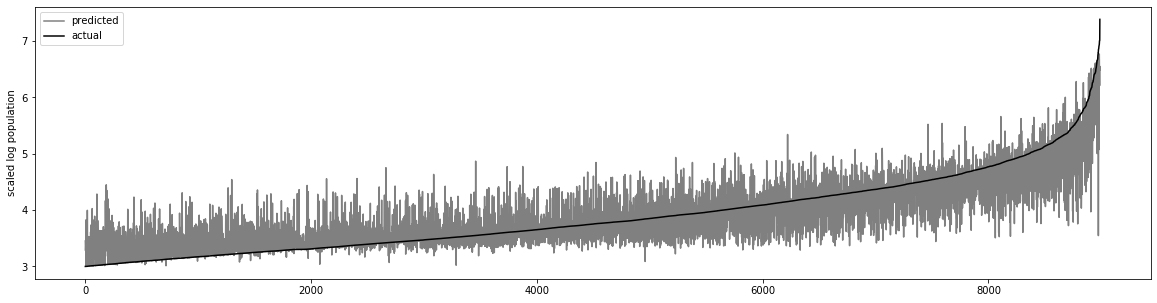

In [25]:
# CELL 25
import math
import random
import cv2
import numpy as np
import time
from sklearn.ensemble import RandomForestRegressor
PARAM_DATA_PATH='./boxes'

header = None
data = list()
with open("ch6_cell32_dev_feat_conservative.tsv") as f:
    header = next(f)
    header = header.strip().split('\t')
    for line in f:
        fields = line.strip().split("\t")
        name = fields.pop(0)
        logpop = float(fields[-1])
        feats = list(map(float, fields[:-1]))
        row = (feats, logpop, name)
        data.append(row)

uri_to_geoid = dict()
with open("ch6_cell1_cities1000_links.ttl") as f:
    for line in f:
        fields = line.split(' ')
        _id = fields[2]
        _id = _id.split('/')[-2]
        uri_to_geoid[fields[0]] = _id
        
# create HOG
hog = cv2.HOGDescriptor( 
    (32, 32), # image size
    (16,16), # normalization block size
    (8,8), # normalization stride
    (8,8), # cell size
    9, # histogram bins
    1, # deriv. aperture
    4, # Gaussian smoothing param
    0, # histogram normalization type
    2.0e-1, # L2-Hys normalization method shrinkage
    0, # gamma correction
    64) # not-used for descriptor
hog_size = hog.getDescriptorSize()

header = list(header[:-1]) + list(map(lambda x: "hog-" + str(x), range(hog_size))) + [ header[-1] ]
for idx, row in enumerate(data):
    if idx % (len(data) // 5) == 0:
        print("Read {:,} out of {:,}".format(idx, len(data)))
    feats, _, name = row
    img = cv2.imread("{}/{}.png".format(PARAM_DATA_PATH, uri_to_geoid[name]))
    #img = cv2.GaussianBlur(img, (3,3), 0)
    r, _, _ = cv2.split(img)
    feats.extend(hog.compute(r[16:48,16:48]).reshape(-1))
    data[idx] = (np.array(feats), row[1], row[2])    

# write full file
with open("ch9_cell25_dev_feat5.tsv",  "w") as f:
    f.write("\t".join(header) + '\n')
    for idx, row in enumerate(data):
        if idx % (len(data) // 5) == 0:
            print("Wrote {:,} out of {:,}".format(idx, len(data)))
        feats, logpop, name = row
        f.write("{}\t{}\t{}\n".format(name, "\t".join(map(lambda x: str(int(x)) if int(x) == x else str(x),
                                                          feats)), logpop))
        
train_data = list()
test_data = list()
rand = random.Random(42)
for row in data:
    if rand.random() < 0.2:
        test_data.append(row) 
    else:
        train_data.append(row)
data=None
               
train_names = list(map(lambda t:t[2], train_data))

test_data = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))
train_names = list(map(lambda t:t[2], train_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xtest = np.array(list(map(lambda t:t[0], test_data)))
ytest = np.array(list(map(lambda t:t[1], test_data)))
train_data=None
test_data=None

# train RF
print("Training on {:,} cities\nusing {:,} features".format(*xtrain.shape))

start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain[:,:98], ytrain)
print("Baseline training took {:,} seconds".format(time.time() - start))
ytest_pred = rfr.predict(xtest[:,:98])
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("Baseline RMSE", RMSE)

start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain, ytrain)
print("Training took {:,} seconds".format(time.time() - start))
ytest_pred = rfr.predict(xtest)
RMSE = math.sqrt(sum((ytest - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

print("Writing files for error analysis")
np.savez_compressed("ch9_cell25_feat5_rf.npz", 
                    xtrain=xtrain, ytrain=ytrain,
                    xtest=xtest, ytest=ytest,
                    ytest_pred=ytest_pred)
import pickle
with open("ch9_cell25_model.pk", "wb") as pkl:
    pickle.dump(rfr, pkl)
with open("ch9_cell25_train_names.tsv", "w") as names:
    for idx, name in enumerate(train_names):
        names.write("{}\t{}\n".format(idx, name))
with open("ch9_cell25_test_names.tsv", "w") as names:
    for idx, name in enumerate(test_names):
        names.write("{}\t{}\n".format(idx, name))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='gray')
plt.plot(ytest, label="actual", color='black')
plt.ylabel('scaled log population')
plt.savefig("ch9_cell25_rf_feat5.pdf", bbox_inches='tight', dpi=300)
plt.legend()

In [26]:
# memory check

import sys
l = list()
for v in dir():
    l.append( (int(eval("sys.getsizeof({})".format(v))), v) )
for c, v in sorted(l, reverse=True)[:20]:
    print("\t{:,}\t{}".format(c,v))

	322,875,808	xtrain_orig
	294,674,544	zca_rescaled
	294,674,544	whitened_train
	121,438,208	xtrain
	80,676,400	xtest_orig
	73,629,808	zca_rescaled_test
	73,629,808	whitened_test
	30,343,600	xtest
	8,388,720	zca
	8,388,720	covar
	8,388,720	E
	6,236,560	geo_id_to_uri
	3,145,856	large
	2,621,552	uri_to_geoid
	2,621,552	pop
	2,621,552	geo_id_to_gps
	2,097,384	tiles
	2,097,384	dev_uris
	786,560	upper_img
	786,560	lower_img
